## Notebook for applying Data Assimilation on seasonal data (Campanian reconstructions)

### Assemble data in the proxy domain using offline (block update) assimilation instead of point-by-point

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

**References used in coding**
- Steiger, N.J., Hakim, G.J., Steig, E.J., Battisti, D.S., Roe, G.H., 2014. Assimilation of Time-Averaged Pseudoproxies for Climate Reconstruction. Journal of Climate 27, 426–441. https://doi.org/10.1175/JCLI-D-12-00693.1
- Hakim, G.J., Emile-Geay, J., Steig, E.J., Noone, D., Anderson, D.M., Tardif, R., Steiger, N., Perkins, W.A., 2016. The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres 121, 6745–6764. https://doi.org/10.1002/2016JD024751
- King, J., Tierney, J., Osman, M., Judd, E.J., Anchukaitis, K.J., 2023. DASH: a MATLAB toolbox for paleoclimate data assimilation. Geoscientific Model Development 16, 5653–5683. https://doi.org/10.5194/gmd-16-5653-2023
- Judd, E.J., Tierney, J.E., Lunt, D.J., Montañez, I.P., Huber, B.T., Wing, S.L., Valdes, P.J., 2024. A 485-million-year history of Earth’s surface temperature. Science 385, eadk3705. https://doi.org/10.1126/science.adk3705
- de Winter, N.J., Müller, I.A., Kocken, I.J., Thibault, N., Ullmann, C.V., Farnsworth, A., Lunt, D.J., Claeys, P., Ziegler, M., 2021. Absolute seasonal temperature estimates from clumped isotopes in bivalve shells suggest warm and variable greenhouse climate. Commun Earth Environ 2, 1–8. https://doi.org/10.1038/s43247-021-00193-9

In [82]:
# FIXME: Offset in D47 values between this and the PWP data. Need to investigate why this is the case.
# Is it the acid correction factor?

# Convert prior D47 to temp
print("Temp of Mean D47 value R. diluvianum according to OGLS:", D47c.OGLS23.T47(D47 = 0.674, sD47 = 0.0, return_covar = True)[0])
print("Temp of Mean D47 value R. diluvianum according to OGLS (subtract AFF):", D47c.OGLS23.T47(D47 = 0.674 - 0.071, sD47 = 0.0, return_covar = True)[0])
print("Temp of Mean D47 value R. diluvianum according to Anderson et al. 2021:", np.sqrt((0.0391 * 10 ** 6)/(0.674 - 0.154)) - 273.15)
print("Temp of Mean D47 value R. diluvianum according to Anderson et al. 2021 (subtract AFF):", np.sqrt((0.0391 * 10 ** 6)/(0.674 - 0.071 - 0.154)) - 273.15)
print("Temp of Mean D47 value R. diluvianum according to Bernasconi et al. 2018 (original paper):", np.sqrt((0.0449 * 10 ** 6)/(0.674 - 0.167)) - 273.15)

Temp of Mean D47 value R. diluvianum according to OGLS: 1.4544475634917262
Temp of Mean D47 value R. diluvianum according to OGLS (subtract AFF): 21.866351366773188
Temp of Mean D47 value R. diluvianum according to Anderson et al. 2021: 1.0621581774004767
Temp of Mean D47 value R. diluvianum according to Anderson et al. 2021 (subtract AFF): 21.947281155234577
Temp of Mean D47 value R. diluvianum according to Bernasconi et al. 2018 (original paper): 24.44058753752114


# Load packages

In [83]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
from sklearn.preprocessing import StandardScaler # Import the package for standardizing data
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import seaborn as sns # The 'seaborn' package is used to make our plots look nicer (e.g. enable heatmaps)
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR - MONTHLY
## Load monthly SST model data

In [84]:
# Load model SST data as prior and show data structure
Campanian_SST = pd.read_csv('Campanian case/Campanian_SST_4CO2.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Campanian_SST.head()

,Cell,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,1,16.69446,15.96928,15.67467,16.28566,18.95221,24.03595,28.790068,30.590389,28.204977,25.071106,21.702738,18.562786
1,2,13.52504,12.20598,11.42650,12.06060,14.92666,19.72694,24.959450,28.078724,26.131413,22.343794,18.724234,15.654868
2,3,11.40485,9.53737,8.53401,9.11727,12.10508,17.21716,22.189592,25.558674,24.180384,19.873465,16.220375,13.532894
3,4,9.85861,8.41774,7.47036,7.73194,10.39034,15.63772,20.783098,23.926445,22.410400,17.623096,13.982187,11.567332
4,5,17.65044,17.04619,16.80905,17.25332,19.25554,23.52535,27.760159,29.674229,27.505966,24.548275,21.602547,19.152851


## Load monthly SSS model data

In [85]:
# Load model SST data as prior and show data structure
Campanian_SSS = pd.read_csv('Campanian case/Campanian_SSS_4CO2.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Campanian_SSS.head()

,Cell,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,1,38.049088,38.408475,38.497470,38.251915,37.729278,37.175676,36.946514,36.743225,36.792417,37.133311,37.474540,37.761063
1,2,34.444552,34.664869,34.553228,34.102059,33.445527,32.853620,32.597889,32.347299,32.406604,32.948889,33.413083,33.987773
2,3,31.022739,31.013631,30.889599,30.465579,29.808659,29.326850,28.892184,28.507395,28.458803,28.719461,29.248610,30.281342
3,4,29.071614,29.532483,29.618115,29.312679,28.508187,27.776942,26.874235,26.238276,25.914295,25.831631,26.406472,27.735042
4,5,38.221195,38.527429,38.604043,38.421331,37.869897,37.236443,36.878951,36.619725,36.769849,37.127605,37.460644,37.872071


### Combine SST and SSS data by modelname

In [86]:
# Merge the datasets of SST and SSS, force suffixes to be added to the column names
Campanian_models = pd.merge(
    Campanian_SST.rename(columns = {c: c+'_SST' for c in Campanian_SST.columns if c != 'Cell'}),
    Campanian_SSS.rename(columns = {c: c+'_SSS' for c in Campanian_SSS.columns if c != 'Cell'}),
    on = 'Cell',
    how = 'outer'
)

# Display the combined dataset
Campanian_models.head()

,Cell,ja_SST,fb_SST,mr_SST,ar_SST,my_SST,jn_SST,jl_SST,ag_SST,sp_SST,...,mr_SSS,ar_SSS,my_SSS,jn_SSS,jl_SSS,ag_SSS,sp_SSS,ot_SSS,nv_SSS,dc_SSS
0,1,16.69446,15.96928,15.67467,16.28566,18.95221,24.03595,28.790068,30.590389,28.204977,...,38.497470,38.251915,37.729278,37.175676,36.946514,36.743225,36.792417,37.133311,37.474540,37.761063
1,2,13.52504,12.20598,11.42650,12.06060,14.92666,19.72694,24.959450,28.078724,26.131413,...,34.553228,34.102059,33.445527,32.853620,32.597889,32.347299,32.406604,32.948889,33.413083,33.987773
2,3,11.40485,9.53737,8.53401,9.11727,12.10508,17.21716,22.189592,25.558674,24.180384,...,30.889599,30.465579,29.808659,29.326850,28.892184,28.507395,28.458803,28.719461,29.248610,30.281342
3,4,9.85861,8.41774,7.47036,7.73194,10.39034,15.63772,20.783098,23.926445,22.410400,...,29.618115,29.312679,28.508187,27.776942,26.874235,26.238276,25.914295,25.831631,26.406472,27.735042
4,5,17.65044,17.04619,16.80905,17.25332,19.25554,23.52535,27.760159,29.674229,27.505966,...,38.604043,38.421331,37.869897,37.236443,36.878951,36.619725,36.769849,37.127605,37.460644,37.872071


### Convert SST model data to D47 domain using the regression by Daëron and Vermeesch (2023) and propagate uncertainty in the calibration

In [87]:
# Apply T47()-function from the D47calib package to all SST columns
# Identify the SST columns
SST_columns = [col for col in Campanian_models.columns if col.endswith('_SST')]

# Apply the conversion function to the SST columns and add new columns for D47 and D47_SE
for col in SST_columns:
    base_col_name = col.replace('_SST', '') # Remove the '_SST' suffix from the column name
    Campanian_models[f'{base_col_name}_D47'], Campanian_models[f'{base_col_name}_D47_SE'] = zip(*Campanian_models[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column

# Display the combined data with D47 and D47_SE columns
D47_columns = [col for col in Campanian_models.columns if col.endswith('_D47')]
D47_se_columns = [col for col in Campanian_models.columns if '_D47_SE' in col]
print("D47 values for all model outcomes:\n", Campanian_models[D47_columns].head())
print("Calibration standard errors for all model outcomes:\n", Campanian_models[D47_se_columns].head())

D47 values for all model outcomes:
      ja_D47    fb_D47    mr_D47    ar_D47    my_D47    jn_D47    jl_D47  \
0  0.619550  0.621943  0.622921  0.620897  0.612214  0.596319  0.582190   
1  0.630147  0.634664  0.637364  0.635166  0.625417  0.609737  0.593520   
2  0.637439  0.644002  0.647583  0.645496  0.635013  0.617836  0.601995   
3  0.642863  0.648000  0.651422  0.650473  0.640988  0.623043  0.606392   
4  0.616422  0.618395  0.619173  0.617718  0.611242  0.597878  0.585193   

     ag_D47    sp_D47    ot_D47    nv_D47    dc_D47  
0  0.577016  0.583892  0.593184  0.603510  0.613467  
1  0.584261  0.590006  0.601517  0.612947  0.622986  
2  0.591718  0.595879  0.609271  0.621112  0.630121  
3  0.596652  0.601310  0.616511  0.628597  0.636875  
4  0.579637  0.585939  0.594763  0.603823  0.611571  
Calibration standard errors for all model outcomes:
    ja_D47_SE  fb_D47_SE  mr_D47_SE  ar_D47_SE  my_D47_SE  jn_D47_SE  \
0   0.001144   0.001156   0.001161   0.001151   0.001111   0.0010

## Calculate the monthly prior for model SST-derived D47 values with propagated uncertainty

In [88]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Set the weights of the data based on the standard errors
weights_monthly = 1 / Campanian_models[[f"{month}_D47_SE" for month in months]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_monthly to match the headers of the D47 matrix later for multiplication
weights_monthly.columns = [col.replace('_D47_SE', '_D47') for col in weights_monthly.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_D47_monthly = np.array((Campanian_models[[f"{month}_D47" for month in months]] * weights_monthly).sum(axis = 0, skipna = True) / weights_monthly.sum(axis = 0, skipna = True)) # Calculate weighted monthal mean D47 values and convert to numpy array

# Decompose variance within and between model outcomes
model_variances = Campanian_models[[f"{month}_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances = (Campanian_models[[f"{month}_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between months in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_monthly = np.cov(Campanian_models[[f"{month}_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_D47_monthly = cov_raw_monthly.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_D47_monthly, np.diagonal(cov_raw_monthly) + measurement_variances)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_D47_monthly_original, cov_prior_D47_monthly_original = mu_prior_D47_monthly.copy(), cov_prior_D47_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_D47_monthly = np.sqrt(np.diag(cov_prior_D47_monthly))

print(mu_prior_D47_monthly)
print(std_prior_D47_monthly)

[0.62973986 0.63330826 0.63516709 0.63371935 0.62585105 0.61159344
 0.59860495 0.59101427 0.59509674 0.60597203 0.61612218 0.62411617]
[0.00987472 0.01095821 0.01181241 0.01180305 0.0107145  0.00964301
 0.00974649 0.00924315 0.00780711 0.00948809 0.01007228 0.00966802]


## Plot the monthly prior for model SST-derived D47 values with propagated uncertainty

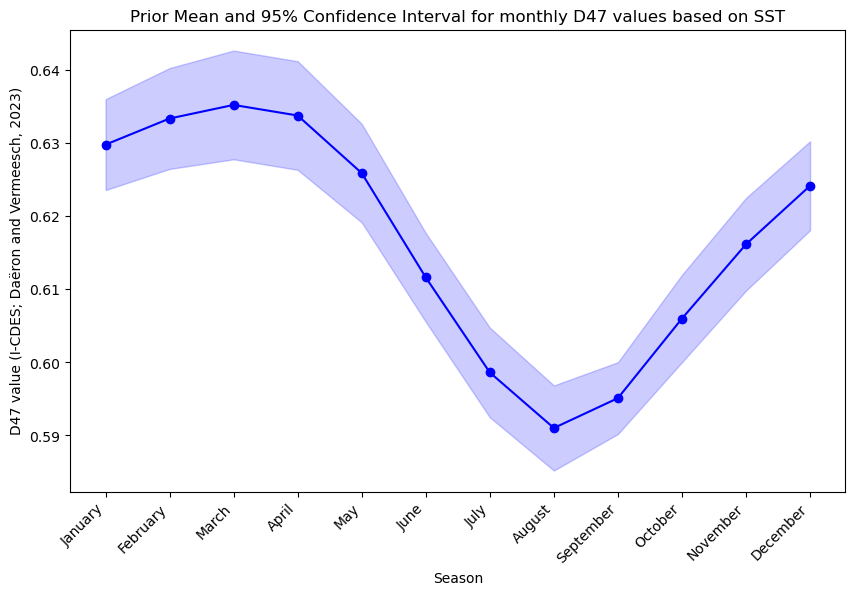

In [89]:
# Establish prior distribution based on monthly Campanian model outcomes

# Set dimensions of data
n_models_monthly = len(Campanian_models["Cell"]) # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Define month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot monthly prior distribution
# Plotting the prior mean and uncertainty
months_scale = np.arange(len(months)) + 1 # Create monthly scale

plt.figure(figsize = (10, 6))
plt.plot(months_scale, mu_prior_D47_monthly, label = 'Prior D47 Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for monthly D47 values based on SST')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.show() # Show plot

## Calculate the monthly prior for model SST and SSS values

In [90]:
# Prior SST & SSS estimates from climate models (mean)
mu_prior_SSS_monthly = np.array(Campanian_models[[f"{month}_SSS" for month in months]].mean(axis = 0, skipna = True))
mu_prior_SST_monthly = np.array(Campanian_models[[f"{month}_SST" for month in months]].mean(axis = 0, skipna = True))

# Covariance between months in prior SST & SSS estimates from climate models (covariance matrix)
cov_prior_SSS_monthly = np.cov(Campanian_models[[f"{month}_SSS" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_monthly = np.cov(Campanian_models[[f"{month}_SST" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SSS_monthly_original, cov_prior_SSS_monthly_original = mu_prior_SSS_monthly.copy(), cov_prior_SSS_monthly.copy()
mu_prior_SST_monthly_original, cov_prior_SST_monthly_original = mu_prior_SST_monthly.copy(), cov_prior_SST_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SSS_monthly = np.sqrt(np.diag(cov_prior_SSS_monthly))
std_prior_SST_monthly = np.sqrt(np.diag(cov_prior_SST_monthly))

print(mu_prior_SSS_monthly)
print(std_prior_SSS_monthly)

[34.38035997 34.64311007 34.68547432 34.38451164 33.78569786 33.28367896
 32.96100648 32.70340301 32.71532687 32.90161951 33.22547048 33.80336539]
[3.06289917 3.05099082 3.07179951 3.14287858 3.23268399 3.2415024
 3.36755931 3.47405737 3.60496929 3.7473411  3.69011806 3.38200736]


## Plot the monthly prior for model SST and SAT values

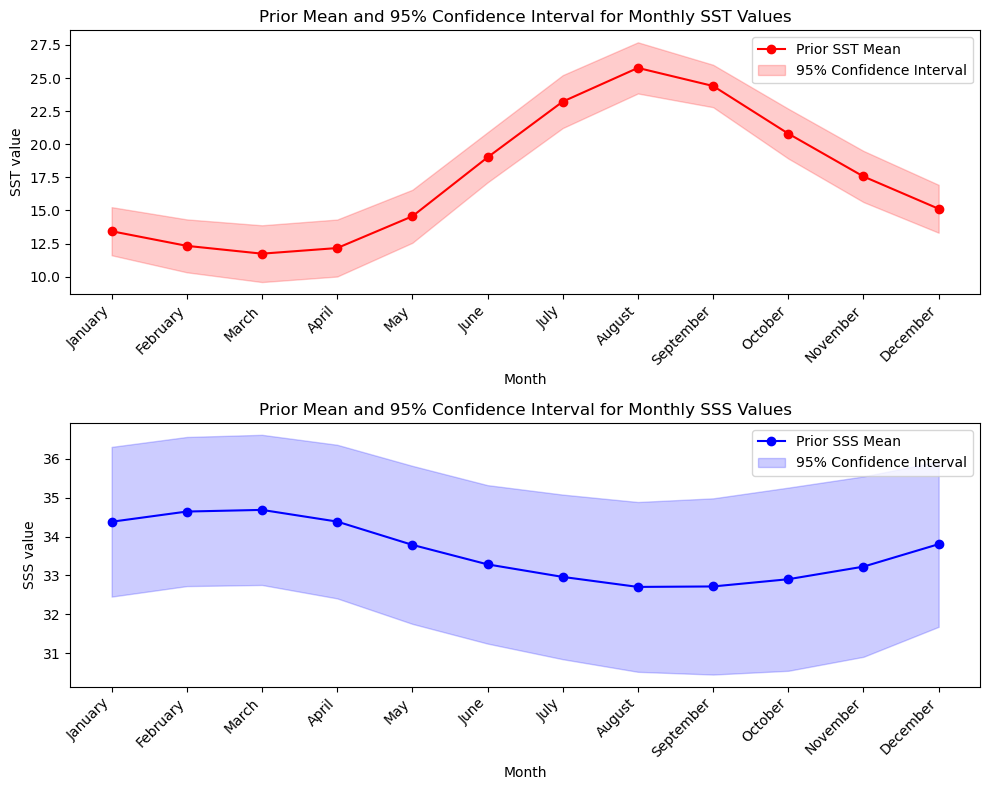

In [91]:
# Plot the prior distribution and confidence envelopes per season for SST & SSS
plt.figure(figsize=(10, 8))

# Plot the prior mean for SST
plt.subplot(2, 1, 1)
plt.plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o', color='r')
plt.fill_between(months_scale,
                 mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                 mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                 alpha=0.2,
                 label='95% Confidence Interval',
                 color='r')
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Prior Mean and 95% Confidence Interval for Monthly SST Values')
plt.xlabel('Month')
plt.ylabel('SST value')
plt.legend()

# Plot the prior mean for SSS
plt.subplot(2, 1, 2)
plt.plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', marker='o', color='b')
plt.fill_between(months_scale,
                 mu_prior_SSS_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
                 mu_prior_SSS_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
                 alpha=0.2,
                 label='95% Confidence Interval',
                 color='b')
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Prior Mean and 95% Confidence Interval for Monthly SSS Values')
plt.xlabel('Month')
plt.ylabel('SSS value')
plt.legend()

plt.tight_layout()
plt.show()

## Calculate the monthly covariance matrix for D47 and SAT values

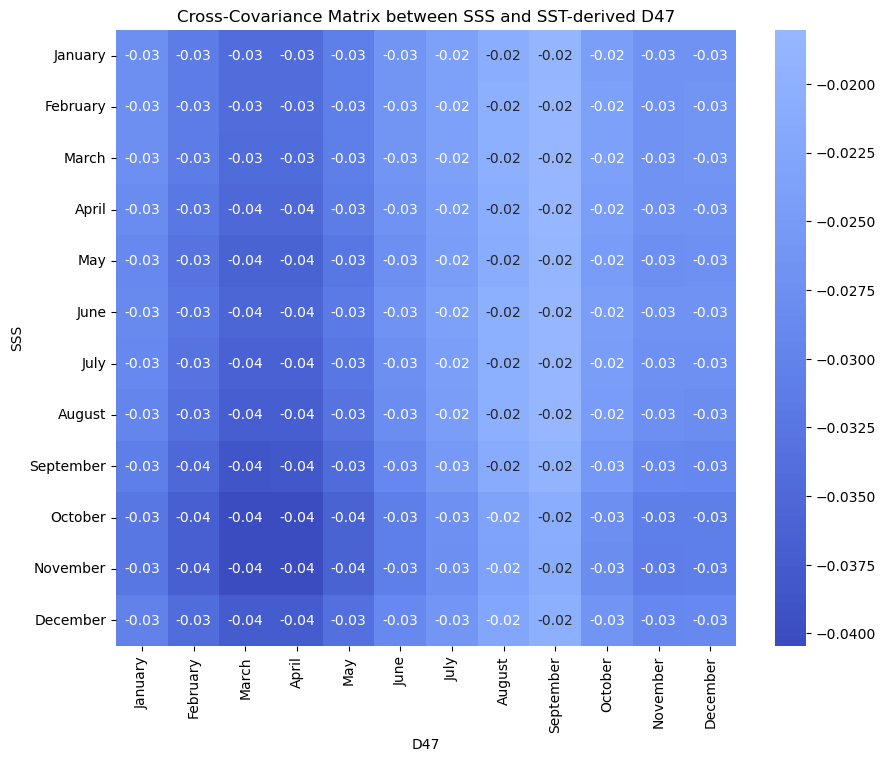

In [92]:
# Extract the relevant columns for SSS, SST, and D47
SSS_columns_monthly = [f"{month}_SSS" for month in months]
D47_columns_monthly = [f"{month}_D47" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = Campanian_models[SSS_columns_monthly + D47_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar = False)

# Extract the covariance matrices for SSS, SST, and D47
cov_SSS_monthly = cov_combined_monthly[:len(months), :len(months)]
cov_D47_monthly = cov_combined_monthly[len(months):, len(months):]

# Extract the cross-covariance matrix
cross_cov_SSS_D47_monthly = cov_combined_monthly[:len(months), len(months):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cross_cov_SSS_D47_monthly,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = month_names,
    yticklabels = month_names
)
plt.title("Cross-Covariance Matrix between SSS and SST-derived D47")
plt.xlabel("D47")
plt.ylabel("SSS")
plt.show()

## Create combined monthly state vector

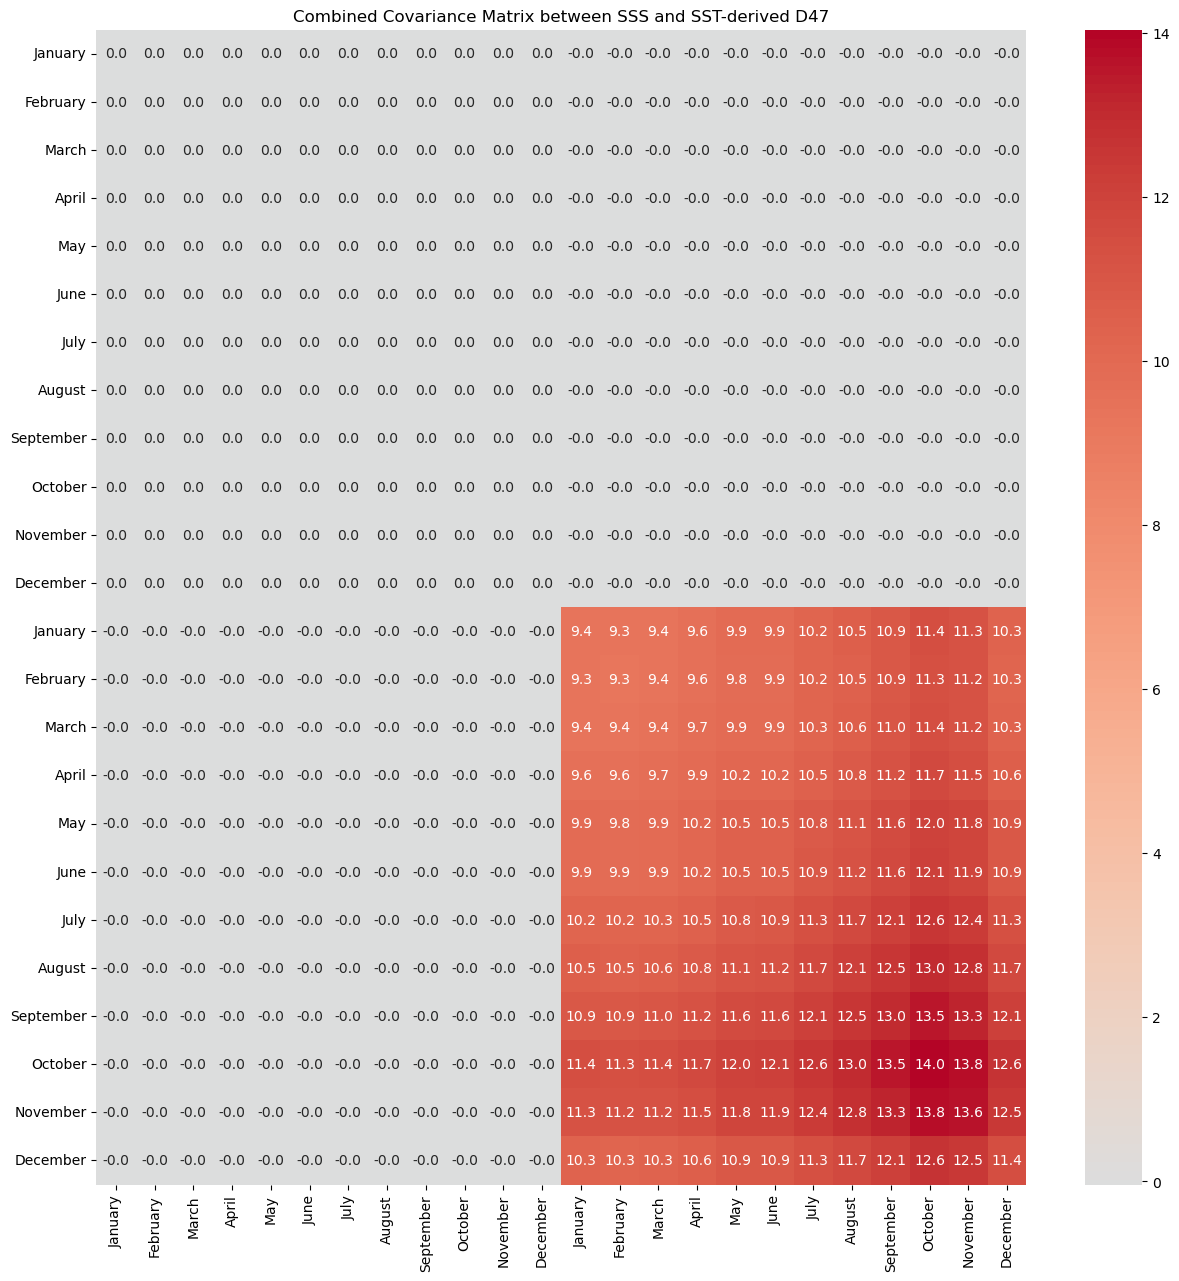

In [93]:
# Combine the prior means of D47 and SSS into a single state vector
mu_prior_monthly_combined = np.concatenate((mu_prior_D47_monthly, mu_prior_SSS_monthly))

# Combine the covariance matrices of D47 and SSS, including the cross-covariance
cov_prior_monthly_combined = np.block([
    [cov_prior_D47_monthly, cross_cov_SSS_D47_monthly],
    [cross_cov_SSS_D47_monthly.T, cov_prior_SSS_monthly]
])

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize = (15, 15))
sns.heatmap(
    cov_prior_monthly_combined,
    annot = True,
    fmt = ".1f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = month_names + month_names,
    yticklabels = month_names + month_names
)
plt.title("Combined Covariance Matrix between SSS and SST-derived D47")
plt.show()

# PRIOR - SEASONAL

## Seasonal model data (convert the PlioMIP data to seasonal means)

In [94]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create a seasonal dataframes
# Initialize dictionaries to store seasonal data
Campanian_models_seasonal_dict = {}

# Identify the columns to process (all except the Cell column)
columns_to_process = [col for col in Campanian_models.columns if any(suffix in col for suffix in ['_SST', '_SSS', '_D47', '_D47_SE'])]

# Process each season
for season, months in seasons.items(): # Iterate over the seasons and corresponding months
    for col in columns_to_process: # Iterate over the columns to process
        base_col_name = col.split('_')[0] # Extract the base column name
        suffix = '_'.join(col.split('_')[1:]) # Extract the suffix
        if base_col_name in months: # Check if the column corresponds to the current season
            season_col_name = f"{season}_{suffix}" # Create the new column name
            if season_col_name not in Campanian_models_seasonal_dict: # Check if the new column name already exists in the seasonal data
                Campanian_models_seasonal_dict[season_col_name] = [] # If not, tnitialize a new column in the seasonal data means
            Campanian_models_seasonal_dict[season_col_name].append(Campanian_models[col])

# Combine the seasonal data into a single dataframe
Campanian_models_seasonal = pd.DataFrame()
for season_col_name, data in Campanian_models_seasonal_dict.items():
    # Concatenate the data for each season and reshape it properly
    concatenated_data = pd.concat(data, axis = 0).reset_index(drop = True)
    Campanian_models_seasonal[season_col_name] = concatenated_data

# Add model names
Campanian_models_seasonal["Cell"] = np.tile(Campanian_models["Cell"].values, 3) # Repeat the model names for each season

# Display the new seasonal DataFrame
D47_columns_seasonal = [col for col in Campanian_models_seasonal.columns if col.endswith('_D47')]
D47_se_columns_seasonal = [col for col in Campanian_models_seasonal.columns if '_D47_SE' in col]
# Campanian_models_seasonal.head()
print("Seasonal D47 values for all SST model outcomes:\n", Campanian_models_seasonal[D47_columns_seasonal].head())
print("Calibration standard errors for all SST model outcomes:\n", Campanian_models_seasonal[D47_se_columns_seasonal].head())

Seasonal D47 values for all SST model outcomes:
    winter_D47  spring_D47  summer_D47  autumn_D47
0    0.619550    0.622921    0.596319    0.583892
1    0.630147    0.637364    0.609737    0.590006
2    0.637439    0.647583    0.617836    0.595879
3    0.642863    0.651422    0.623043    0.601310
4    0.616422    0.619173    0.597878    0.585939
Calibration standard errors for all SST model outcomes:
    winter_D47_SE  spring_D47_SE  summer_D47_SE  autumn_D47_SE
0       0.001144       0.001161       0.001061       0.001043
1       0.001202       0.001249       0.001101       0.001050
2       0.001249       0.001322       0.001136       0.001060
3       0.001287       0.001352       0.001162       0.001073
4       0.001129       0.001142       0.001065       0.001045


## Calculate the seasonal prior for model SST-derived D47 values with propagated uncertainty

In [95]:
# Define the seasons
seasons = ["winter", "spring", "summer", "autumn"]

# Set the weights of the data based on the standard errors
weights_seasonal = 1 / Campanian_models_seasonal[[f"{season}_D47_SE" for season in seasons]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_seasonal to match the headers of the D47 matrix later for multiplication
weights_seasonal.columns = [col.replace('_D47_SE', '_D47') for col in weights_seasonal.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_D47_seasonal = np.array((Campanian_models_seasonal[[f"{season}_D47" for season in seasons]] * weights_seasonal).sum(axis = 0, skipna = True) / weights_seasonal.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array

# Decompose variance within and between model outcomes
model_variances = Campanian_models_seasonal[[f"{season}_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances = (Campanian_models_seasonal[[f"{season}_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between seasons in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_seasonal = np.cov(Campanian_models_seasonal[[f"{season}_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_D47_seasonal = cov_raw_seasonal.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_D47_seasonal, np.diagonal(cov_raw_seasonal) + measurement_variances)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_D47_seasonal_original, cov_prior_D47_seasonal_original = mu_prior_D47_seasonal.copy(), cov_prior_D47_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_D47_seasonal = np.sqrt(np.diag(cov_prior_D47_seasonal))

## Plot the seasonal prior for model SST-derived D47 values with propagated uncertainty

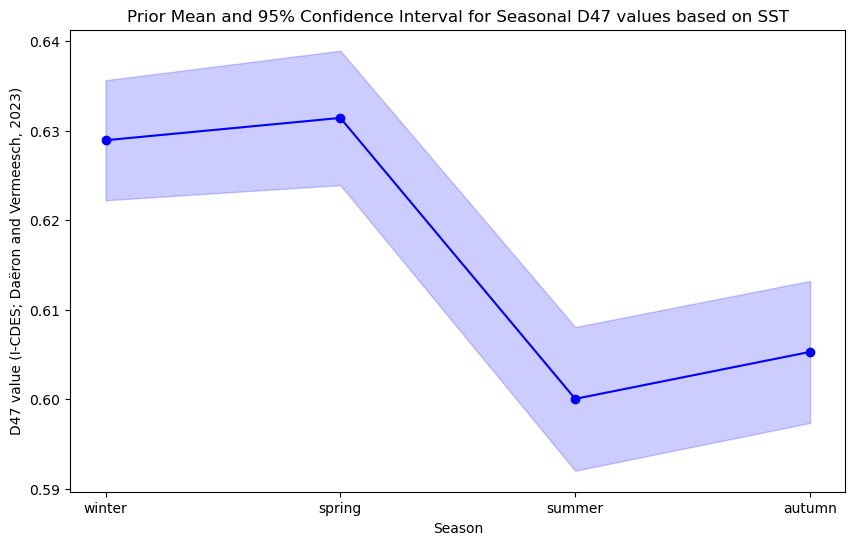

In [96]:
# Establish prior distribution based on seasonal Campanian model outcomes

# Set dimensions of data
n_models_seasonal = len(Campanian_models["Cell"]) # Find the total number of models (use monthly data because seasonal data has this column duplicated 3 times)

# Plot seasonal prior distribution
# Plotting the prior mean and uncertainty
seasons_scale = np.arange(len(seasons)) + 1 # Create seasonal scale

plt.figure(figsize = (10, 6))
plt.plot(seasons_scale, mu_prior_D47_seasonal, label = 'Prior D47 Mean', color = 'b', marker = 'o')
plt.title('Prior Mean and 95% Confidence Interval for Seasonal D47 values based on SST')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')

# Adding 95% confidence intervals (mean ± 1.96 * standard deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# Update the x-axis with month names
plt.xticks(seasons_scale, seasons)
plt.show() # Show plot

## Calculate the seasonal prior for model SST and SAT values

In [97]:
# Prior SST & SSS estimates from climate models (mean)
mu_prior_SSS_seasonal = np.array(Campanian_models_seasonal[[f"{season}_SSS" for season in seasons]].mean(axis = 0, skipna = True))
mu_prior_SST_seasonal = np.array(Campanian_models_seasonal[[f"{season}_SST" for season in seasons]].mean(axis = 0, skipna = True))

# Covariance between seasons in prior SST & SSS estimates from climate models (covariance matrix)
cov_prior_SSS_seasonal = np.cov(Campanian_models_seasonal[[f"{season}_SSS" for season in seasons]].dropna(), rowvar=False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_seasonal = np.cov(Campanian_models_seasonal[[f"{season}_SST" for season in seasons]].dropna(), rowvar=False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SSS_seasonal_original, cov_prior_SSS_seasonal_original = mu_prior_SSS_seasonal.copy(), cov_prior_SSS_seasonal.copy()
mu_prior_SST_seasonal_original, cov_prior_SST_seasonal_original = mu_prior_SST_seasonal.copy(), cov_prior_SST_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SSS_seasonal = np.sqrt(np.diag(cov_prior_SSS_seasonal))
std_prior_SST_seasonal = np.sqrt(np.diag(cov_prior_SST_seasonal))

print(mu_prior_SSS_seasonal)
print(std_prior_SSS_seasonal)

[34.27561181 34.28522794 32.98269615 32.94747229]
[3.09762627 3.08191841 3.27376733 3.5809339 ]


## Plot the seasonal prior for model SAT values

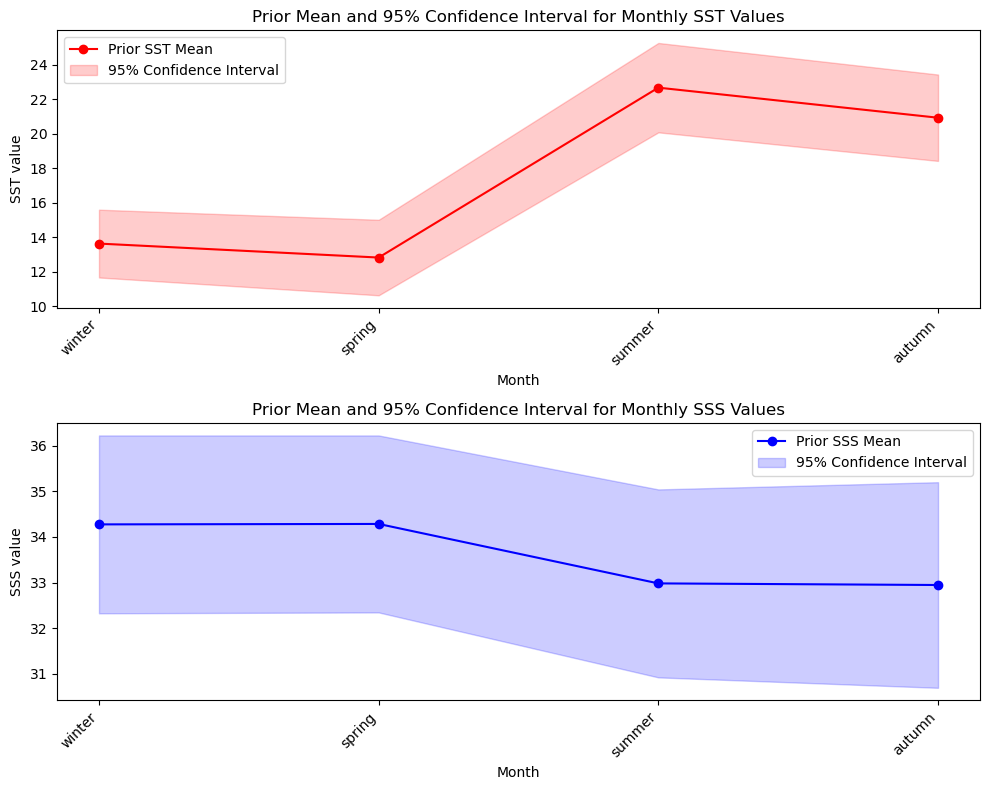

In [98]:
# Plot the prior distribution and confidence envelopes per season for SST & SSS
plt.figure(figsize=(10, 8))

# Plot the prior mean for SST
plt.subplot(2, 1, 1)
plt.plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o', color='r')
plt.fill_between(seasons_scale,
                 mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                 mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                 alpha=0.2,
                 label='95% Confidence Interval',
                 color='r')
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.title('Prior Mean and 95% Confidence Interval for Monthly SST Values')
plt.xlabel('Month')
plt.ylabel('SST value')
plt.legend(loc='upper left')

# Plot the prior mean for SSS
plt.subplot(2, 1, 2)
plt.plot(seasons_scale, mu_prior_SSS_seasonal, label='Prior SSS Mean', marker='o', color='b')
plt.fill_between(seasons_scale,
                 mu_prior_SSS_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
                 mu_prior_SSS_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
                 alpha=0.2,
                 label='95% Confidence Interval',
                 color='b')
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.title('Prior Mean and 95% Confidence Interval for Monthly SSS Values')
plt.xlabel('Month')
plt.ylabel('SSS value')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Calculate the seasonal covariance matrix for D47 and SAT values

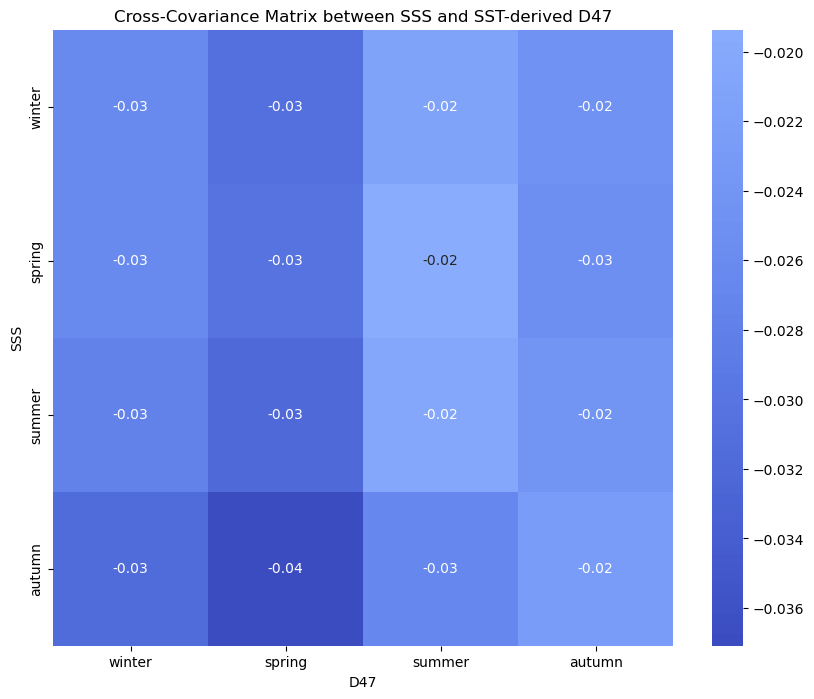

In [99]:
# Extract the relevant columns for SSS, SST, and D47
SSS_columns_seasonal = [f"{season}_SSS" for season in seasons]
d47_columns_seasonal = [f"{season}_D47" for season in seasons]

# Combine the relevant columns into a single dataframe
combined_data_seasonal = Campanian_models_seasonal[SSS_columns_seasonal + d47_columns_seasonal]

# Calculate the covariance matrix for the combined data
cov_combined_seasonal = np.cov(combined_data_seasonal.dropna(), rowvar = False)

# Extract the covariance matrices for SSS, SST, and D47
cov_SSS_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_D47_seasonal = cov_combined_seasonal[len(seasons):, len(seasons):]

# Extract the cross-covariance matrix
cross_cov_SSS_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cross_cov_SSS_D47_seasonal,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = seasons,
    yticklabels = seasons
)
plt.title("Cross-Covariance Matrix between SSS and SST-derived D47")
plt.xlabel("D47")
plt.ylabel("SSS")
plt.show()

## Create combined seasonal state vector

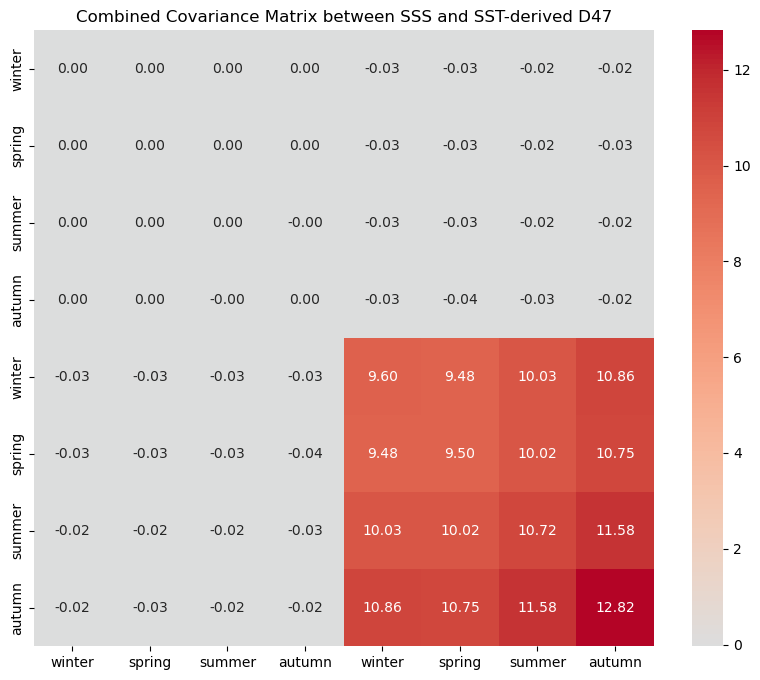

In [100]:
# Combine the prior means of D47 and SSS into a single state vector
mu_prior_seasonal_combined = np.concatenate((mu_prior_D47_seasonal, mu_prior_SSS_seasonal))

# Combine the covariance matrices of D47 and SSS, including the cross-covariance
cov_prior_seasonal_combined = np.block([
    [cov_prior_D47_seasonal, cross_cov_SSS_D47_seasonal],
    [cross_cov_SSS_D47_seasonal.T, cov_prior_SSS_seasonal]
])

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cov_prior_seasonal_combined,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = seasons + seasons,
    yticklabels = seasons + seasons
)
plt.title("Combined Covariance Matrix between SSS and SST-derived D47")
plt.show()

# OBSERVATIONS
## Load clumped data for updating
### Monthly data from Kristianstad paper (de Winter et al., 2021)

In [101]:
# Load seasonal measurements and format them into a dictionary
# This is precompiled seasonal data per specimen and therefore does not come with a time uncertainty
Campanian_monthly_aggregated_data = pd.read_csv('Campanian case/Kristianstad_seasonal_data.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Campanian_monthly_aggregated_data_dict = Campanian_monthly_aggregated_data.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because data is already aggregated monthly)
for record in Campanian_monthly_aggregated_data_dict:
    record["Month_err"] = 0 # Set the time uncertainty to zero
    record["D47"], record["D47_se"] = D47c.OGLS23.T47(T = record["T_median"], sT = record["T_SE"]) # Calculate the D47 value and its uncertainty from the reconstruced monthly temperature

print(Campanian_monthly_aggregated_data_dict[0]) # Print to check the structure of the data

{'Month': 1, 'Month_align': 6, 'N_sample': 10, 'T_median': 28.38, 'T_95CL': 1.87, 'T_SE': 1.031746268, 'd18Osw_median': 0.97, 'd18Osw_95CL': 0.31, 'd18Ow_SE': 0.171038151, 'species': 'R_diluvianum', 'Month_err': 0, 'D47': 0.5833820226938509, 'D47_se': 0.003180623686789519}


### Monthly raw data at the sample level

In [102]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
Campanian_D47_data = pd.read_csv('Campanian case/Kristianstad_raw_data.csv') # Load the data for this assignment into Python and in the Jupyter environment.
Campanian_D47_data_dict = Campanian_D47_data.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because there is no time uncertainty in the raw data)
for record in Campanian_D47_data_dict:
    record["Month_err"] = 0 # Set the time uncertainty to zero
    record["D47"] = record["Final_D47"] - 0.071 # Subtract the acid fractionation factor from the D47 value to project back into I-CDES reference frame

print(Campanian_D47_data_dict[0]) # Print to check the structure of the data

{'Specimen': 'R. diluvianum', 'ID': '002', 'd13C ': 0.805, 'd13C_SD': 0.011056171, 'd18Occ ': -1.479, 'd18O_SD': 0.011056171, 'Final_D47': 0.71, 'D47_SD': 0.171543583, 'Modelled age': 0.169863014, 'Modelled age_align': 0.586529681, 'Month_err': 0, 'D47': 0.639}


## Summarize proxy data to seasonal bins

In [103]:
# Define the seasons for proxy data
proxy_seasons = {
    0: [12, 1, 2],
    1: [3, 4, 5],
    2: [6, 7, 8],
    3: [9, 10, 11]
}

# Add seasonal ID to the proxy data
for record in Campanian_D47_data_dict:
    record["Season_err"] = 0 # Set the season error to zero
    month = math.ceil(record["Modelled age_align"] * 12) # Round up the modelled age to the nearest month
    record["Month"] = month # Add the month to the record
    for season, months in proxy_seasons.items():
        if month in months:
            record["season_score"] = season
            break

for record in Campanian_monthly_aggregated_data_dict:
    record["Season_err"] = 0 # Set the season error to zero
    month = record["Month_align"]
    for season, months in proxy_seasons.items():
        if month in months:
            record["season_score"] = season
            break

print(Campanian_D47_data_dict[0]) # Print to check the structure of the data
print(Campanian_monthly_aggregated_data_dict[0]) # Print to check the structure of the data

{'Specimen': 'R. diluvianum', 'ID': '002', 'd13C ': 0.805, 'd13C_SD': 0.011056171, 'd18Occ ': -1.479, 'd18O_SD': 0.011056171, 'Final_D47': 0.71, 'D47_SD': 0.171543583, 'Modelled age': 0.169863014, 'Modelled age_align': 0.586529681, 'Month_err': 0, 'D47': 0.639, 'Season_err': 0, 'Month': 8, 'season_score': 2}
{'Month': 1, 'Month_align': 6, 'N_sample': 10, 'T_median': 28.38, 'T_95CL': 1.87, 'T_SE': 1.031746268, 'd18Osw_median': 0.97, 'd18Osw_95CL': 0.31, 'd18Ow_SE': 0.171038151, 'species': 'R_diluvianum', 'Month_err': 0, 'D47': 0.5833820226938509, 'D47_se': 0.003180623686789519, 'Season_err': 0, 'season_score': 2}


## Prepare measurement and observation matrices

### Define a wrapped normal distribution to allow uncertainty in the time domain to flow around the year

In [104]:
# Function to calculate wrapped normal distribution weights
def wrapped_normal_pdf(x, mean, sd, num_bins):
    # Calculate the normal PDF for each bin
    pdf = stats.norm.pdf(x, loc = mean, scale = sd)
    # Wrap around the bins
    for i in range(1, num_bins):
        pdf += stats.norm.pdf(x + i * num_bins, loc = mean, scale = sd)
        pdf += stats.norm.pdf(x - i * num_bins, loc = mean, scale = sd)
    # Normalize the weights to ensure the sum equals 1
    pdf /= pdf.sum()
    return pdf

### Measurement matrix for monthly-averaged D47 values per specimen

In [105]:
# Extract measurements and uncertainties from the dictionary
measurements_monthly_aggregated = [measurement["D47"] for measurement in Campanian_monthly_aggregated_data_dict] # Extract the D47 values
measurements_monthly_aggregated_se = [measurement["D47_se"] ** 2 for measurement in Campanian_monthly_aggregated_data_dict] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_monthly_aggregated = np.array(measurements_monthly_aggregated).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_monthly_aggregated = np.diag(measurements_monthly_aggregated_se)

# Number of seasonally averaged measurements
N_measurements_monthly_aggregated = len(measurements_monthly_aggregated)

### Observation matrices for monthly- and season-averaged D47 data from monthly aggregated data

In [106]:
# Create the observation matrix H for monthly and seasonal data based on monthly and specimen aggregated data
H_monthly_aggregated = np.zeros((N_measurements_monthly_aggregated, len(mu_prior_monthly_combined)))
H_seasonal_aggregated = np.zeros((N_measurements_monthly_aggregated, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(Campanian_monthly_aggregated_data_dict):
    month_index = int(measurement["Month_align"]) - 1
    season_index = int(measurement["season_score"])
    H_monthly_aggregated[i, month_index] = 1
    H_seasonal_aggregated[i, season_index] = 1

print(H_monthly_aggregated)
print(H_seasonal_aggregated)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.

### Measurement matrix for individual D47 values

In [107]:
# Extract measurements and uncertainties from the dictionary, skipping missing values
measurements = [measurement["D47"] for measurement in Campanian_D47_data_dict if not pd.isna(measurement["D47"])] # Extract the D47 values
measurement_uncertainties = [measurement["D47_SD"] ** 2 for measurement in Campanian_D47_data_dict if not pd.isna(measurement["D47"])] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_samples = np.array(measurements).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_samples = np.diag(measurement_uncertainties)

# Number of measurements
N_measurements = len(measurements)

### Observation matrix for monthly and seasonal D47 data from individual D47 values

In [108]:
# Create the observation matrix H for monthly data based on individual measurements
H_monthly = np.zeros((N_measurements, len(mu_prior_monthly_combined)))
H_seasonal = np.zeros((N_measurements, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
i = 0 # Count the number of stored values, ignoring NaNa in the D47 values
for measurement in Campanian_D47_data_dict:
    if not pd.isna(measurement["D47"]):  # Check if the D47 value is not NaN
        month_index = int(measurement["Month"]) - 1
        season_index = int(measurement["season_score"])
        H_monthly[i, month_index] = 1
        H_seasonal[i, season_index] = 1
        i = i + 1 # increment the number of stored values

print(H_monthly)
print(H_seasonal)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


# UPDATE

## Create updating function (Kalman filter)
- Include updating of second variable (SAT) through cross-covariance
- Use block updating

Input:
- Prior means (mu_prior)
- Prior covariance matrix (P)
- Observation matrix (H)
- Measurement matrix (Z)
- Uncertainty matrix (R)

Output:
- Posterior means (mu_post)
- Posterior covariance matrix (P_post)

In [109]:
def kalman_update_block(
    mu_prior: np.ndarray,
    cov_prior: np.ndarray,
    Z: np.ndarray,
    R: np.ndarray,
    H: np.ndarray
):
    """
    Perform a Kalman update step for a block of observations.

    Parameters:
    mu_prior (np.ndarray): The prior mean vector.
    cov_prior (np.ndarray): The prior covariance matrix.
    Z (np.ndarray): The measurement matrix.
    R (np.ndarray): The measurement noise covariance matrix.
    H (np.ndarray): The observation matrix.

    Returns:
    mu_posterior (np.ndarray): The posterior mean vector.
    cov_posterior (np.ndarray): The posterior covariance matrix.
    """
    # Print shapes of key variables for debugging
    print("Shape of cov_prior:", cov_prior.shape)
    print("Shape of H:", H.shape)
    print("Shape of R:", R.shape)
    print("Shape of mu_prior:", mu_prior.shape)
    print("Shape of Z:", Z.shape)

    # Compute the Kalman gain
    K = cov_prior @ H.T @ np.linalg.inv(H @ cov_prior @ H.T + R)
    print("Shape of K:", K.shape)

    # In-between steps for debugging
    Y_hat = H @ mu_prior # Compute the predicted observation
    print("Shape of Y_hat:", Y_hat.shape)
    innovation = Z - Y_hat.reshape(-1, 1) # Compute the innovation
    print("Shape of innovation:", innovation.shape)
    kalman_gain = K @ innovation # Compute the Kalman gain
    print("Shape of kalman_gain:", kalman_gain.shape)

    # Update the posterior mean estimate
    mu_posterior = mu_prior + kalman_gain.flatten()

    # Update the posterior covariance estimate
    cov_posterior = cov_prior - K @ H @ cov_prior

    return mu_posterior, cov_posterior


## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [110]:
# Create function to keep track of the likelihood statistics and data

# Suppress FutureWarning
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def likelihood_statistics(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_name = "Variable_name",
    Variable_name_SD = "Variable_name_SD"
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin.
    - n_update: list
        List tracking the number of datapoints for each time bin.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing seasonal and temperature data.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: str
        Key in the measurement dictionary for the time bin (e.g. month or season).
    - Variable_name_SD: str
        Key in the measurement dictionary for the standard deviation on the age model (e.g. month or season).
    """
    if timestamp in measurement and Variable_name in measurement and Variable_name_SD in measurement:
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        data_val = measurement[Variable_name]
        data_sd = measurement[Variable_name_SD]
        
        # print(time, time_sd, data_val, data_sd) # Print to check the values

        # Check if the data is valid
        if not np.isnan(data_val) and not np.isnan(data_sd):
            # Calculate the weight (inverse of variance)
            weight = 1 / (data_sd ** 2)
                        
            # Determine the number of bins
            num_bins = len(weighted_sum)
            bin_indices = np.arange(num_bins, dtype = np.float64)
            
            # Calculate the probability density for each bin
            if time_sd == 0: # Catch cases where the time uncertainty is zero (or unknown)
                probabilities = np.zeros(num_bins, dtype = np.float64)
                bin_index = int(time) % num_bins  # Ensure the bin index is within range
                probabilities[bin_index] = 1 # Set the probability to 1 for the correct bin
            else:
                probabilities = stats.norm.pdf(bin_indices, loc = time, scale = time_sd) # For non-zero time uncertainty, use a normal distribution
                probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1
            
            for i, prob in enumerate(probabilities): # Loop over all possible bin numbers in the probability vector
                bin_index = i % num_bins  # Wrap around to the first bin if it overflows
                
                # Update the weighted sums and sample count
                effective_weight = weight * prob
                if weighted_sum[bin_index] is None:
                    weighted_sum[bin_index] = 0
                    effective_weights_total[bin_index] = 0
                weighted_sum[bin_index] = weighted_sum[bin_index] + data_val * effective_weight
                effective_weights_total[bin_index] = effective_weights_total[bin_index] + effective_weight
            
            n_update[int(time) % num_bins] = n_update[int(time) % num_bins] + 1 # update sample number per bin

            # Track individual data points and their uncertainties
            if time not in data_library:
                data_library[int(time)] = []  # Initialize the list for a new time bin
            data_library[int(time)].append((time_sd, data_val, data_sd))
    
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

## EXECUTE UPDATING FUNCTIONS

## Update seasonal prior with aggregated data
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per month, then per season

In [111]:
# Apply Kalman function to update the prior with seasonal data including updating the SSS estimates
# Update the seasonal D47 and SSS prior with all measurements using block updating
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal_aggregated = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal_aggregated, cov_post_seasonal_aggregated = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated,
    H_seasonal_aggregated
)

# Extract the updated D47 and SSS values from the combined state vector
mu_post_D47_seasonal_aggregated = mu_post_seasonal_aggregated[:len(mu_prior_D47_seasonal)]
mu_post_SSS_seasonal_aggregated = mu_post_seasonal_aggregated[len(mu_prior_D47_seasonal):]

# Extract the updated covariance matrices for D47 and SSS
cov_post_D47_seasonal_aggregated = cov_post_seasonal_aggregated[:len(mu_prior_D47_seasonal), :len(mu_prior_D47_seasonal)]
cov_post_SSS_seasonal_aggregated = cov_post_seasonal_aggregated[len(mu_prior_D47_seasonal):, len(mu_prior_D47_seasonal):]

for measurement in Campanian_monthly_aggregated_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_seasonal_aggregated, effective_weights_total_seasonal_aggregated, n_update_seasonal_aggregated, seasonal_data = likelihood_statistics(
        weighted_sum_seasonal_aggregated,
        effective_weights_total_seasonal_aggregated,
        n_update_seasonal_aggregated,
        seasonal_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Season_err",
        Variable_name = "D47",
        Variable_name_SD = "D47_se"
    )

# Normalize the weighted_sum_seasonal_aggregated to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal_aggregated to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal_aggregated)):
    if effective_weights_total_seasonal_aggregated[i] is not None and effective_weights_total_seasonal_aggregated[i] != 0:
        mu_likelihood_seasonal_aggregated[i] = weighted_sum_seasonal_aggregated[i] / effective_weights_total_seasonal_aggregated[i]
        std_likelihood_seasonal_aggregated[i] = np.sqrt(1 / effective_weights_total_seasonal_aggregated[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal_aggregated[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal_aggregated[i]}")
    print(f"Number of Data Points: {n_update_seasonal_aggregated[i]}\n")

print("Original Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal_original)
print("Original Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal_original)))
print("Updated Prior Mean D47 Seasonal:\n", mu_post_D47_seasonal_aggregated)
print("Updated Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_post_D47_seasonal_aggregated)))
print("Original Prior Mean SSS Seasonal:\n", mu_prior_SSS_seasonal_original)
print("Original Prior Standard Deviation SSS Seasonal:\n", np.sqrt(np.diag(cov_prior_SSS_seasonal_original)))
print("Updated Prior Mean SSS Seasonal:\n", mu_post_SSS_seasonal_aggregated)
print("Updated Prior Standard Deviation SSS Seasonal:\n", np.sqrt(np.diag(cov_post_SSS_seasonal_aggregated)))

Shape of cov_prior: (8, 8)
Shape of H: (36, 8)
Shape of R: (36, 36)
Shape of mu_prior: (8,)
Shape of Z: (36, 1)
Shape of K: (8, 36)
Shape of Y_hat: (36,)
Shape of innovation: (36, 1)
Shape of kalman_gain: (8, 1)
Likelihood statistics:
Month: 1
Weighted Average D47: 0.6198444855746882
Aggregated Uncertainty (D47_sd): 0.0011515131643211815
Number of Data Points: 9.0

Month: 2
Weighted Average D47: 0.6160384018064754
Aggregated Uncertainty (D47_sd): 0.0011608051167779796
Number of Data Points: 9.0

Month: 3
Weighted Average D47: 0.5925003129583183
Aggregated Uncertainty (D47_sd): 0.0012921729285015418
Number of Data Points: 9.0

Month: 4
Weighted Average D47: 0.6098808324156638
Aggregated Uncertainty (D47_sd): 0.0011111217135964817
Number of Data Points: 9.0

Original Prior Mean D47 Seasonal:
 [0.62890998 0.63140503 0.60002437 0.6052713 ]
Original Prior Standard Deviation D47 Seasonal:
 [0.01066062 0.01193445 0.0127614  0.01261045]
Updated Prior Mean D47 Seasonal:
 [0.61935591 0.61699349 

C:\Users\nwi213\AppData\Local\Temp\ipykernel_12336\3690382454.py:62: RuntimeWarning: invalid value encountered in sqrt
  print("Updated Prior Standard Deviation SSS Seasonal:\n", np.sqrt(np.diag(cov_post_SSS_seasonal_aggregated)))


### Plot seasonal posterior in D47 domain

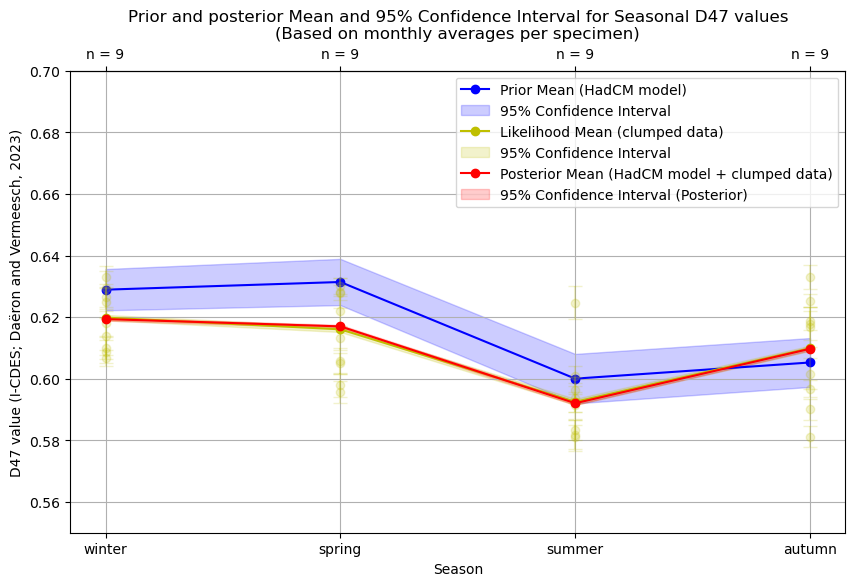

In [112]:
# Plot the updated seasonal posterior
std_post_D47_seasonal_aggregated = np.sqrt(np.diag(cov_post_D47_seasonal_aggregated))
std_prior_D47_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_aggregated - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated),
    mu_likelihood_seasonal_aggregated + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Campanian_monthly_aggregated_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, measurement["D47"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, measurement["D47"], yerr = measurement["D47_se"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_D47_seasonal_aggregated, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_D47_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    mu_post_D47_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal D47 values\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update monthly prior with aggregated data
* Data and model outcomes aggregated in 12 months
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per month

In [113]:
# Apply Kalman function to update the prior with Monthly data including updating the SSS estimates
# Update the Monthly D47 and SSS prior with all measurements using block updating
monthly_data = {} # Keep track of datapoints per season
n_update_monthly_aggregated = mu_prior_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly_aggregated = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly_aggregated = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly_aggregated = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly_aggregated = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with Monthly data using the Kalman filter in block updating form
mu_post_monthly_aggregated, cov_post_monthly_aggregated = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated,
    H_monthly_aggregated
)

# Extract the updated D47 and SSS values from the combined state vector
mu_post_D47_monthly_aggregated = mu_post_monthly_aggregated[:len(mu_prior_D47_monthly)]
mu_post_SSS_monthly_aggregated = mu_post_monthly_aggregated[len(mu_prior_D47_monthly):]

# Extract the updated covariance matrices for D47 and SSS
cov_post_D47_monthly_aggregated = cov_post_monthly_aggregated[:len(mu_prior_D47_monthly), :len(mu_prior_D47_monthly)]
cov_post_SSS_monthly_aggregated = cov_post_monthly_aggregated[len(mu_prior_D47_monthly):, len(mu_prior_D47_monthly):]

for measurement in Campanian_monthly_aggregated_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_monthly_aggregated, effective_weights_total_monthly_aggregated, n_update_monthly_aggregated, Monthly_data = likelihood_statistics(
        weighted_sum_monthly_aggregated,
        effective_weights_total_monthly_aggregated,
        n_update_monthly_aggregated,
        monthly_data,
        measurement,
        timestamp = "Month_align",
        timestamp_sd = "Season_err",
        Variable_name = "D47",
        Variable_name_SD = "D47_se"
    )

# Normalize the weighted_sum_monthly_aggregated to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly_aggregated to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly_aggregated)):
    if effective_weights_total_monthly_aggregated[i] is not None and effective_weights_total_monthly_aggregated[i] != 0:
        mu_likelihood_monthly_aggregated[i] = weighted_sum_monthly_aggregated[i] / effective_weights_total_monthly_aggregated[i]
        std_likelihood_monthly_aggregated[i] = np.sqrt(1 / effective_weights_total_monthly_aggregated[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly_aggregated[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly_aggregated[i]}")
    print(f"Number of Data Points: {n_update_monthly_aggregated[i]}\n")

print("Original Prior Mean D47 Monthly:\n", mu_prior_D47_monthly_original)
print("Original Prior Standard Deviation D47 Monthly:\n", np.sqrt(np.diag(cov_prior_D47_monthly_original)))
print("Updated Prior Mean D47 Monthly:\n", mu_post_D47_monthly_aggregated)
print("Updated Prior Standard Deviation D47 Monthly:\n", np.sqrt(np.diag(cov_post_D47_monthly_aggregated)))
print("Original Prior Mean SSS Monthly:\n", mu_prior_SSS_monthly_original)
print("Original Prior Standard Deviation SSS Monthly:\n", np.sqrt(np.diag(cov_prior_SSS_monthly_original)))
print("Updated Prior Mean SSS Monthly:\n", mu_post_SSS_monthly_aggregated)
print("Updated Prior Standard Deviation SSS Monthly:\n", np.sqrt(np.diag(cov_post_SSS_monthly_aggregated)))

Shape of cov_prior: (24, 24)
Shape of H: (36, 24)
Shape of R: (36, 36)
Shape of mu_prior: (24,)
Shape of Z: (36, 1)
Shape of K: (24, 36)
Shape of Y_hat: (36,)
Shape of innovation: (36, 1)
Shape of kalman_gain: (24, 1)
Likelihood statistics:
Month: 1
Weighted Average D47: 0.6216722513974969
Aggregated Uncertainty (D47_sd): 0.0016370284183866684
Number of Data Points: 3.0

Month: 2
Weighted Average D47: 0.6162635135591888
Aggregated Uncertainty (D47_sd): 0.002279577609482528
Number of Data Points: 3.0

Month: 3
Weighted Average D47: 0.6198820238664653
Aggregated Uncertainty (D47_sd): 0.0023028639991969774
Number of Data Points: 3.0

Month: 4
Weighted Average D47: 0.6236237974548682
Aggregated Uncertainty (D47_sd): 0.0020314742072981683
Number of Data Points: 3.0

Month: 5
Weighted Average D47: 0.6176786557774364
Aggregated Uncertainty (D47_sd): 0.0018538892803766705
Number of Data Points: 3.0

Month: 6
Weighted Average D47: 0.6049530110080908
Aggregated Uncertainty (D47_sd): 0.0021881283

C:\Users\nwi213\AppData\Local\Temp\ipykernel_12336\2957144287.py:62: RuntimeWarning: invalid value encountered in sqrt
  print("Updated Prior Standard Deviation SSS Monthly:\n", np.sqrt(np.diag(cov_post_SSS_monthly_aggregated)))


### Plot monthly posterior in D47 domain

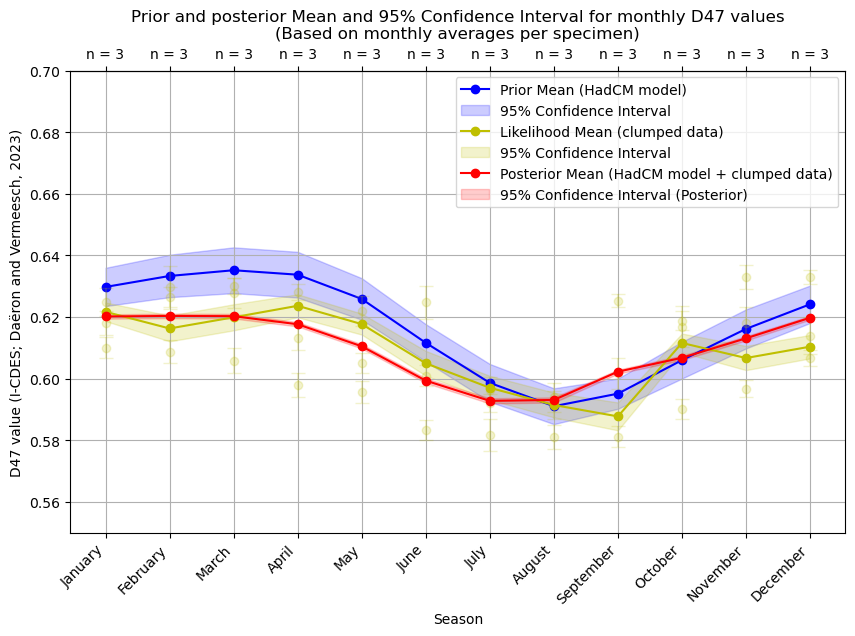

In [128]:
# Plot the updated monthly posterior
std_post_D47_monthly_aggregated = np.sqrt(np.diag(cov_post_D47_monthly_aggregated))
std_prior_D47_monthly_original = np.sqrt(np.diag(cov_prior_D47_monthly_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_aggregated, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_aggregated - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated) * std_likelihood_monthly_aggregated / np.sqrt(n_update_monthly_aggregated),
    mu_likelihood_monthly_aggregated + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated) * std_likelihood_monthly_aggregated / np.sqrt(n_update_monthly_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Campanian_monthly_aggregated_data_dict: # Loop over measurements
    plt.plot(measurement["Month_align"], measurement["D47"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["Month_align"], measurement["D47"], yerr = measurement["D47_se"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_D47_monthly_aggregated, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_D47_monthly_aggregated - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated + n_models_monthly)) * std_post_D47_monthly_aggregated / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    mu_post_D47_monthly_aggregated + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated + n_models_monthly)) * std_post_D47_monthly_aggregated / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for monthly D47 values\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with individual datapoints
* Aggregate data and model outcomes in 4 seasons based on individual D47 datapoints
* No sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [115]:
# Apply Kalman function to update the prior with seasonal data including updating the SSS estimates
# Update the seasonal D47 and SSS prior with all measurements using block updating
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal = mu_prior_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal = mu_prior_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal, cov_post_seasonal = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_samples,
    R_samples,
    H_seasonal
)

# Extract the updated D47 and SSS values from the combined state vector
mu_post_D47_seasonal = mu_post_seasonal[:len(mu_prior_D47_seasonal)]
mu_post_SSS_seasonal = mu_post_seasonal[len(mu_prior_D47_seasonal):]

# Extract the updated covariance matrices for D47 and SSS
cov_post_D47_seasonal = cov_post_seasonal[:len(mu_prior_D47_seasonal), :len(mu_prior_D47_seasonal)]
cov_post_SSS_seasonal = cov_post_seasonal[len(mu_prior_D47_seasonal):, len(mu_prior_D47_seasonal):]

for measurement in Campanian_D47_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_seasonal, effective_weights_total_seasonal, n_update_seasonal, seasonal_data = likelihood_statistics(
        weighted_sum_seasonal,
        effective_weights_total_seasonal,
        n_update_seasonal,
        seasonal_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Season_err",
        Variable_name = "D47",
        Variable_name_SD = "D47_SD"
    )

# Normalize the weighted_sum_seasonal to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal)):
    if effective_weights_total_seasonal[i] is not None and effective_weights_total_seasonal[i] != 0:
        mu_likelihood_seasonal[i] = weighted_sum_seasonal[i] / effective_weights_total_seasonal[i]
        std_likelihood_seasonal[i] = np.sqrt(1 / effective_weights_total_seasonal[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal[i]}")
    print(f"Number of Data Points: {n_update_seasonal[i]}\n")

print("Original Prior Mean D47 Seasonal:\n", mu_prior_D47_seasonal_original)
print("Original Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_D47_seasonal_original)))
print("Updated Prior Mean D47 Seasonal:\n", mu_post_D47_seasonal)
print("Updated Prior Standard Deviation D47 Seasonal:\n", np.sqrt(np.diag(cov_post_D47_seasonal)))
print("Original Prior Mean SSS Seasonal:\n", mu_prior_SSS_seasonal_original)
print("Original Prior Standard Deviation SSS Seasonal:\n", np.sqrt(np.diag(cov_prior_SSS_seasonal_original)))
print("Updated Prior Mean SSS Seasonal:\n", mu_post_SSS_seasonal)
print("Updated Prior Standard Deviation SSS Seasonal:\n", np.sqrt(np.diag(cov_post_SSS_seasonal)))

Shape of cov_prior: (8, 8)
Shape of H: (338, 8)
Shape of R: (338, 338)
Shape of mu_prior: (8,)
Shape of Z: (338, 1)
Shape of K: (8, 338)
Shape of Y_hat: (338,)
Shape of innovation: (338, 1)
Shape of kalman_gain: (8, 1)
Likelihood statistics:
Month: 1
Weighted Average D47: 0.6297390447447997
Aggregated Uncertainty (D47_sd): 0.0074218560283557545
Number of Data Points: 104.0

Month: 2
Weighted Average D47: 0.6336586028330572
Aggregated Uncertainty (D47_sd): 0.008582881547558378
Number of Data Points: 111.0

Month: 3
Weighted Average D47: 0.6217555079140217
Aggregated Uncertainty (D47_sd): 0.011327157807578522
Number of Data Points: 75.0

Month: 4
Weighted Average D47: 0.5985762762118153
Aggregated Uncertainty (D47_sd): 0.016702300517910676
Number of Data Points: 48.0

Original Prior Mean D47 Seasonal:
 [0.62890998 0.63140503 0.60002437 0.6052713 ]
Original Prior Standard Deviation D47 Seasonal:
 [0.01066062 0.01193445 0.0127614  0.01261045]
Updated Prior Mean D47 Seasonal:
 [0.63135558 0

### Plot seasonal posterior in D47 domain

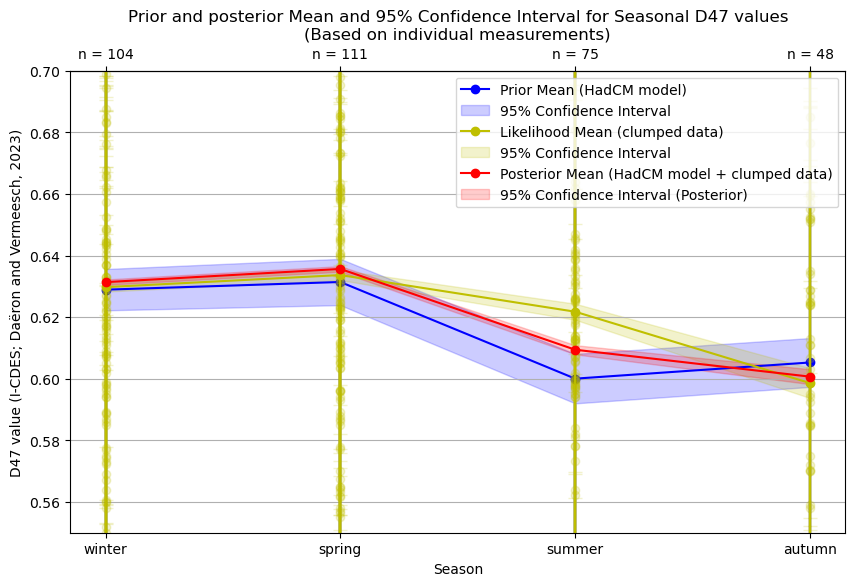

In [116]:
# Plot the updated seasonal posterior
std_post_D47_seasonal = np.sqrt(np.diag(cov_post_D47_seasonal))
std_prior_D47_seasonal_original = np.sqrt(np.diag(cov_prior_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Campanian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, measurement["D47"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, measurement["D47"], yerr = measurement["D47_SD"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_D47_seasonal, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_D47_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_D47_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_D47_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_D47_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update monthly prior with individual datapoints
* Aggregate data and model outcomes in 12 seasons based on individual D47 datapoints
* No sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [125]:
# Apply Kalman function to update the prior with monthly data including updating the SSS estimates
# Update the monthly D47 and SSS prior with all measurements using block updating
seasonal_data = {} # Keep track of datapoints per season
n_update_monthly = mu_prior_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly = mu_prior_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with monthly data using the Kalman filter in block updating form
mu_post_monthly, cov_post_monthly = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_samples,
    R_samples,
    H_monthly
)

# Extract the updated D47 and SSS values from the combined state vector
mu_post_D47_monthly = mu_post_monthly[:len(mu_prior_D47_monthly)]
mu_post_SSS_monthly = mu_post_monthly[len(mu_prior_D47_monthly):]

# Extract the updated covariance matrices for D47 and SSS
cov_post_D47_monthly = cov_post_monthly[:len(mu_prior_D47_monthly), :len(mu_prior_D47_monthly)]
cov_post_SSS_monthly = cov_post_monthly[len(mu_prior_D47_monthly):, len(mu_prior_D47_monthly):]

for measurement in Campanian_D47_data_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_monthly, effective_weights_total_monthly, n_update_monthly, monthly_data = likelihood_statistics(
        weighted_sum_monthly,
        effective_weights_total_monthly,
        n_update_monthly,
        monthly_data,
        measurement,
        timestamp = "Month",
        timestamp_sd = "Month_err",
        Variable_name = "D47",
        Variable_name_SD = "D47_SD"
    )

# Normalize the weighted_sum_monthly to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly)):
    if effective_weights_total_monthly[i] is not None and effective_weights_total_monthly[i] != 0:
        mu_likelihood_monthly[i] = weighted_sum_monthly[i] / effective_weights_total_monthly[i]
        std_likelihood_monthly[i] = np.sqrt(1 / effective_weights_total_monthly[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly[i]}")
    print(f"Number of Data Points: {n_update_monthly[i]}\n")

print("Original Prior Mean D47 monthly:\n", mu_prior_D47_monthly_original)
print("Original Prior Standard Deviation D47 monthly:\n", np.sqrt(np.diag(cov_prior_D47_monthly_original)))
print("Updated Prior Mean D47 monthly:\n", mu_post_D47_monthly)
print("Updated Prior Standard Deviation D47 monthly:\n", np.sqrt(np.diag(cov_post_D47_monthly)))
print("Original Prior Mean SSS monthly:\n", mu_prior_SSS_monthly_original)
print("Original Prior Standard Deviation SSS monthly:\n", np.sqrt(np.diag(cov_prior_SSS_monthly_original)))
print("Updated Prior Mean SSS monthly:\n", mu_post_SSS_monthly)
print("Updated Prior Standard Deviation SSS monthly:\n", np.sqrt(np.diag(cov_post_SSS_monthly)))

Shape of cov_prior: (24, 24)
Shape of H: (338, 24)
Shape of R: (338, 338)
Shape of mu_prior: (24,)
Shape of Z: (338, 1)
Shape of K: (24, 338)
Shape of Y_hat: (338,)
Shape of innovation: (338, 1)
Shape of kalman_gain: (24, 1)
Likelihood statistics:
Month: 1
Weighted Average D47: 0.6179161147305969
Aggregated Uncertainty (D47_sd): 0.024211259104259943
Number of Data Points: 25.0

Month: 2
Weighted Average D47: 0.631280659854089
Aggregated Uncertainty (D47_sd): 0.013157105797028274
Number of Data Points: 31.0

Month: 3
Weighted Average D47: 0.6307945545367895
Aggregated Uncertainty (D47_sd): 0.009680278655309238
Number of Data Points: 48.0

Month: 4
Weighted Average D47: 0.6452121703591854
Aggregated Uncertainty (D47_sd): 0.01229649580268708
Number of Data Points: 34.0

Month: 5
Weighted Average D47: 0.6289788873389384
Aggregated Uncertainty (D47_sd): 0.014801322674063557
Number of Data Points: 44.0

Month: 6
Weighted Average D47: 0.6106892538379464
Aggregated Uncertainty (D47_sd): 0.0204

C:\Users\nwi213\AppData\Local\Temp\ipykernel_12336\1337407667.py:62: RuntimeWarning: invalid value encountered in sqrt
  print("Updated Prior Standard Deviation SSS monthly:\n", np.sqrt(np.diag(cov_post_SSS_monthly)))


### Plot monthly posterior in D47 domain

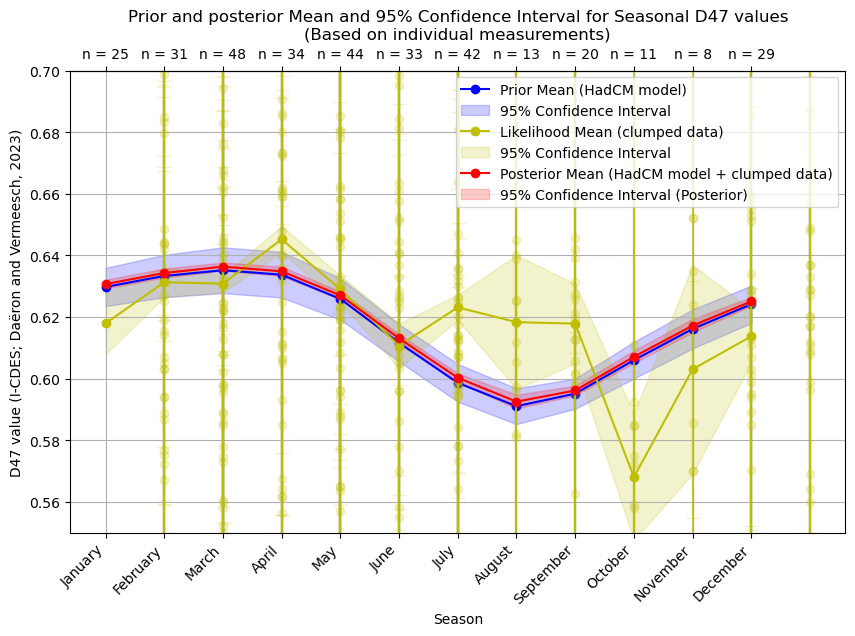

In [129]:
# Plot the updated seasonal posterior
std_post_D47_monthly = np.sqrt(np.diag(cov_post_D47_monthly))
std_prior_D47_monthly_original = np.sqrt(np.diag(cov_prior_D47_monthly_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_original / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly),
    mu_likelihood_monthly + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Campanian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["Month"] + 1, measurement["D47"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["Month"] + 1, measurement["D47"], yerr = measurement["D47_SD"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_D47_monthly, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_D47_monthly - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_D47_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_D47_monthly + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_D47_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

# POSTERIORS IN SST AND SSS DOMAIN

## Updated seasonal prior in SST and SSS domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per month, then per season

### Convert seasonal prior, likelihood and posterior to temperature and plot

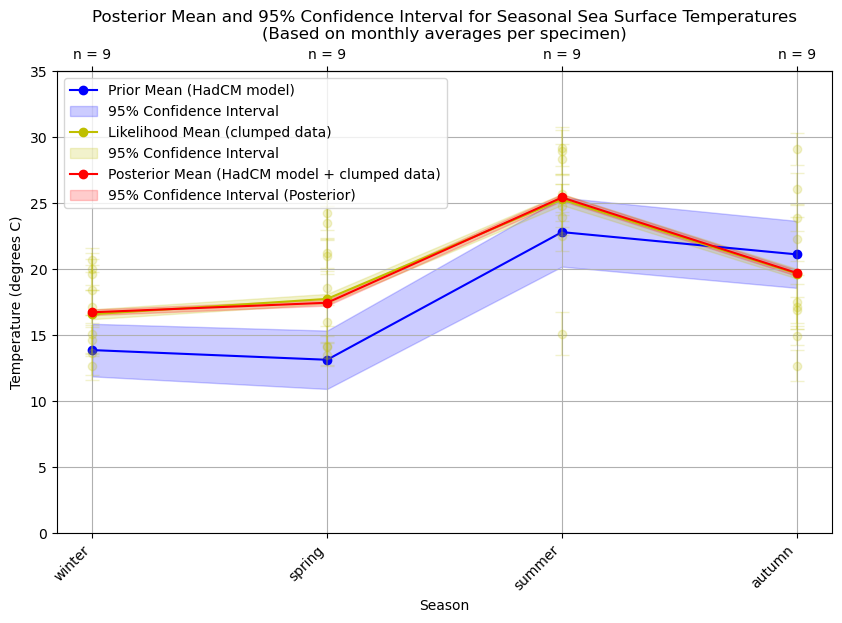

In [137]:
# Convert prior D47 to temp
mu_prior_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[0]
cov_prior_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated, sD47 = std_likelihood_seasonal_aggregated, return_covar = True)[0]
cov_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated, sD47 = std_likelihood_seasonal_aggregated, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal_aggregated, sD47 = cov_post_D47_seasonal_aggregated, return_covar = True)[0]
cov_posterior_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal_aggregated, sD47 = cov_post_D47_seasonal_aggregated, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_seasonal_aggregated_T = np.sqrt(np.diag(cov_prior_D47_seasonal_aggregated_T))
std_likelihood_seasonal_aggregated_T = np.sqrt(np.diag(cov_likelihood_seasonal_aggregated_T))
std_posterior_seasonal_aggregated_T = np.sqrt(np.diag(cov_posterior_seasonal_aggregated_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_aggregated_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_aggregated_T / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_aggregated_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated),
    mu_likelihood_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Campanian_monthly_aggregated_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_se"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_se"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_se"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_aggregated_T, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    mu_posterior_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SSS prior and posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_12336\925347883.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_SSS_seasonal_aggregated = np.nan_to_num(np.sqrt(np.diag(cov_post_SSS_seasonal_aggregated)))


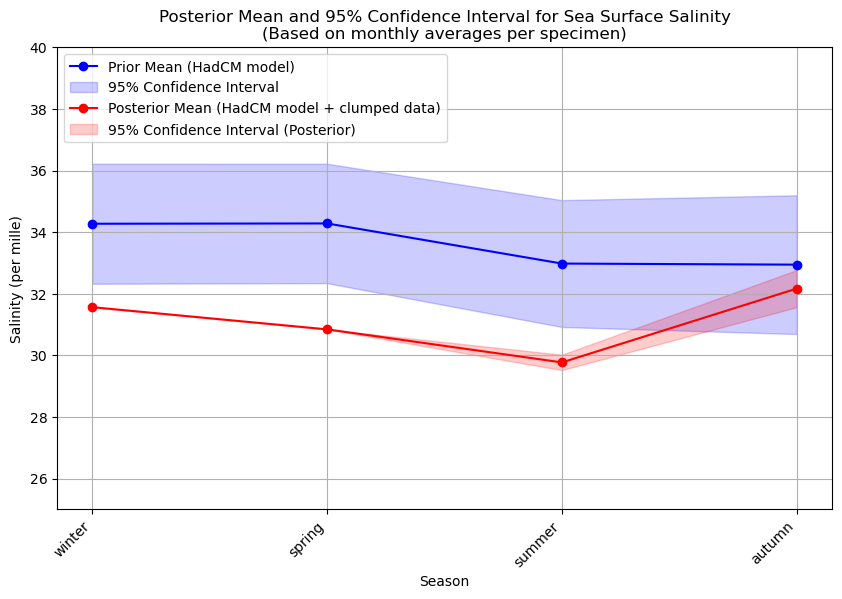

In [146]:
# Plot in temperature domain, set nan values to zero
std_prior_SSS_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_prior_SSS_seasonal_original)))
std_posterior_SSS_seasonal_aggregated = np.nan_to_num(np.sqrt(np.diag(cov_post_SSS_seasonal_aggregated)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SSS_seasonal_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SSS_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SSS_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SSS_seasonal_aggregated, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SSS_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SSS_seasonal_aggregated / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_SSS_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SSS_seasonal_aggregated / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Sea Surface Salinity\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Salinity (per mille)')
plt.ylim(25, 40)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SST and SSS and posterior

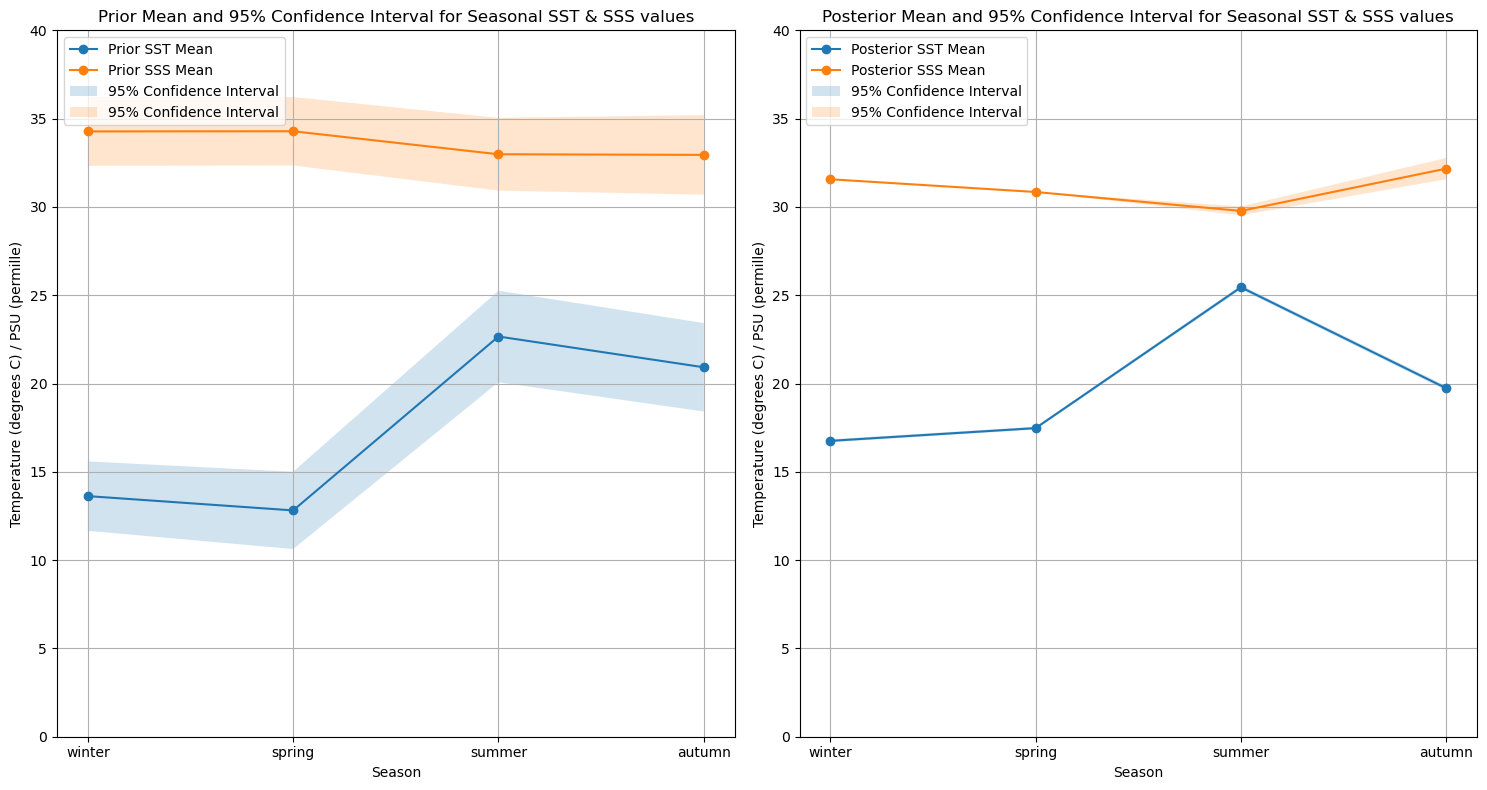

In [140]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SSS
axes[0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o')
axes[0].plot(seasons_scale, mu_prior_SSS_seasonal, label='Prior SSS Mean', marker='o')
axes[0].fill_between(seasons_scale,
                     mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(seasons_scale,
                     mu_prior_SSS_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SSS_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SSS values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C) / PSU (permille)')
axes[0].set_ylim(0, 40)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SSS
axes[1].plot(seasons_scale, mu_posterior_seasonal_aggregated_T, label='Posterior SST Mean', marker='o')
axes[1].plot(seasons_scale, mu_post_SSS_seasonal_aggregated, label='Posterior SSS Mean', marker='o')
axes[1].fill_between(seasons_scale,
                     mu_posterior_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_posterior_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(seasons_scale,
                     mu_post_SSS_seasonal_aggregated - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_SSS_seasonal_aggregated / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SSS_seasonal_aggregated + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_SSS_seasonal_aggregated / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SST & SSS values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C) / PSU (permille)')
axes[1].set_ylim(0, 40)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Updated monthly prior in SST and SSS domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen and per month, then per season

### Convert seasonal prior, likelihood and posterior to temperature and plot

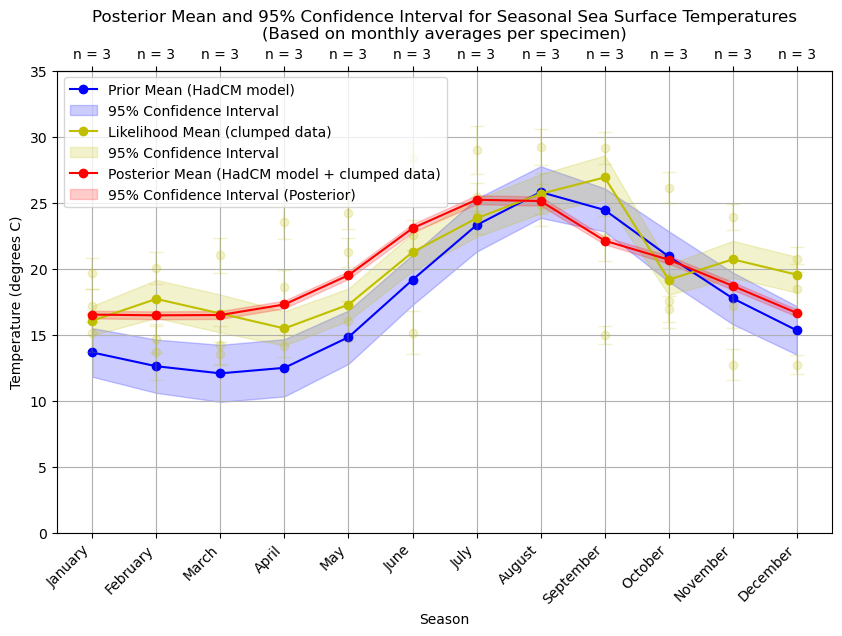

In [142]:
# Convert prior D47 to temp
mu_prior_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly_original, sD47 = cov_prior_D47_monthly_original, return_covar = True)[0]
cov_prior_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly_original, sD47 = cov_prior_D47_monthly_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_aggregated, sD47 = std_likelihood_monthly_aggregated, return_covar = True)[0]
cov_likelihood_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_aggregated, sD47 = std_likelihood_monthly_aggregated, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_D47_monthly_aggregated, sD47 = cov_post_D47_monthly_aggregated, return_covar = True)[0]
cov_posterior_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_D47_monthly_aggregated, sD47 = cov_post_D47_monthly_aggregated, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_monthly_aggregated_T = np.sqrt(np.diag(cov_prior_D47_monthly_aggregated_T))
std_likelihood_monthly_aggregated_T = np.sqrt(np.diag(cov_likelihood_monthly_aggregated_T))
std_posterior_monthly_aggregated_T = np.sqrt(np.diag(cov_posterior_monthly_aggregated_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_aggregated_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_aggregated_T / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_aggregated_T / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_aggregated_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated) * std_likelihood_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated),
    mu_likelihood_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated) * std_likelihood_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Campanian_monthly_aggregated_data_dict: # Loop over measurements
    plt.plot(measurement["Month_align"], D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_se"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["Month_align"], D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_se"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_se"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_posterior_monthly_aggregated_T, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_posterior_monthly_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated + n_models_monthly)) * std_posterior_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    mu_posterior_monthly_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated + n_models_monthly)) * std_posterior_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SSS prior and posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_12336\3196947351.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_SSS_monthly_aggregated = np.nan_to_num(np.sqrt(np.diag(cov_post_SSS_monthly_aggregated)))


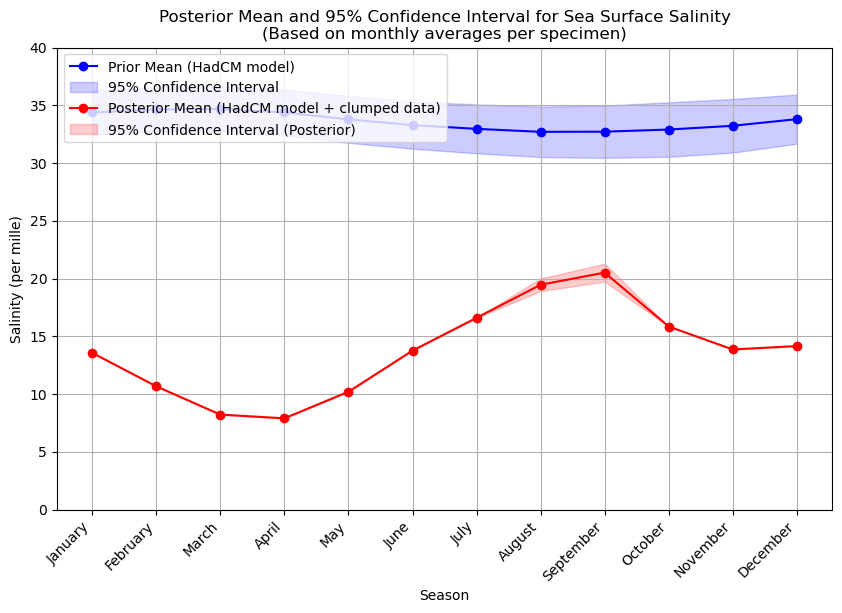

In [147]:
# Plot in temperature domain, set nan values to zero
std_prior_SSS_monthly = np.nan_to_num(np.sqrt(np.diag(cov_prior_SSS_monthly_original)))
std_posterior_SSS_monthly_aggregated = np.nan_to_num(np.sqrt(np.diag(cov_post_SSS_monthly_aggregated)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SSS_monthly_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SSS_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
    mu_prior_SSS_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SSS_monthly_aggregated, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SSS_monthly_aggregated - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_SSS_monthly_aggregated / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_SSS_monthly_aggregated + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_SSS_monthly_aggregated / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Sea Surface Salinity\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Salinity (per mille)')
plt.ylim(0, 40)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SST and SSS and posterior

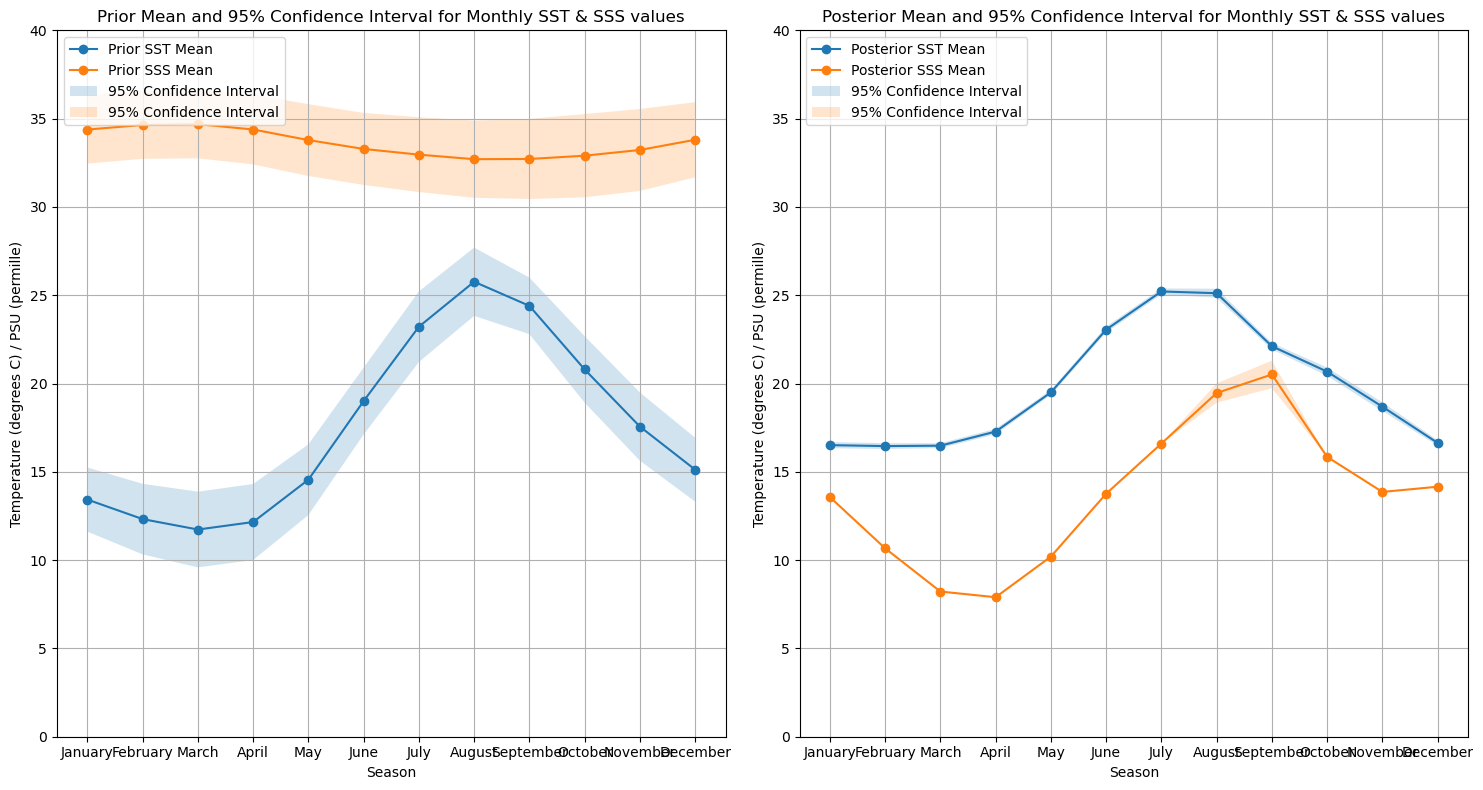

In [148]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SSS
axes[0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o')
axes[0].plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', marker='o')
axes[0].fill_between(months_scale,
                     mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(months_scale,
                     mu_prior_SSS_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SSS_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(months_scale)
axes[0].set_xticklabels(month_names)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST & SSS values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C) / PSU (permille)')
axes[0].set_ylim(0, 40)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SSS
axes[1].plot(months_scale, mu_posterior_monthly_aggregated_T, label='Posterior SST Mean', marker='o')
axes[1].plot(months_scale, mu_post_SSS_monthly_aggregated, label='Posterior SSS Mean', marker='o')
axes[1].fill_between(months_scale,
                     mu_posterior_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_monthly_aggregated_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_posterior_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_monthly_aggregated_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(months_scale,
                     mu_post_SSS_monthly_aggregated - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_SSS_monthly_aggregated / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_post_SSS_monthly_aggregated + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_SSS_monthly_aggregated / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(months_scale)
axes[1].set_xticklabels(month_names)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Monthly SST & SSS values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C) / PSU (permille)')
axes[1].set_ylim(0, 40)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Updated seasonal prior in SST and SSS domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 data aggregated as individual datapoints

### Convert seasonal prior, likelihood and posterior to temperature and plot

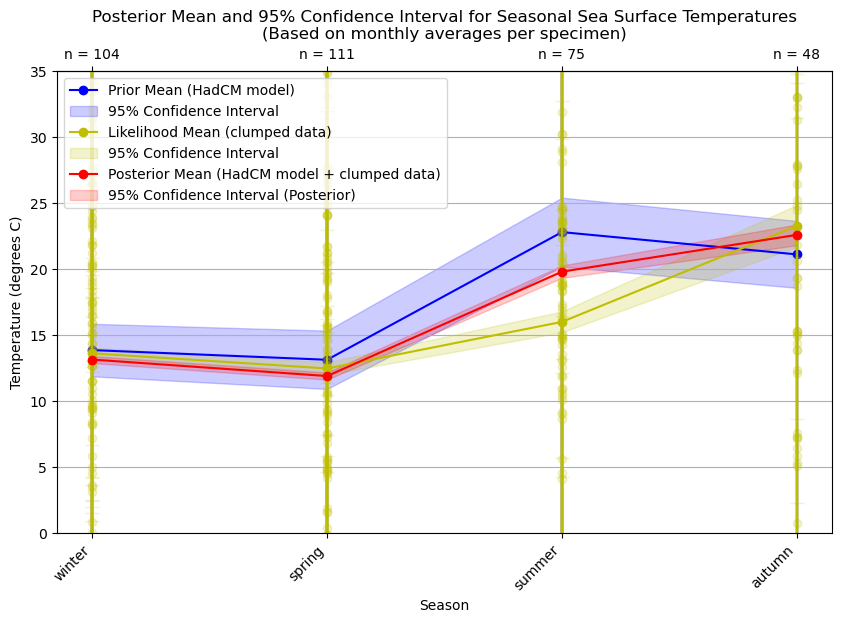

In [149]:
# Convert prior D47 to temp
mu_prior_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[0]
cov_prior_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_D47_seasonal_original, sD47 = cov_prior_D47_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[0]
cov_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal, sD47 = cov_post_D47_seasonal, return_covar = True)[0]
cov_posterior_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_D47_seasonal, sD47 = cov_post_D47_seasonal, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_seasonal_T = np.sqrt(np.diag(cov_prior_D47_seasonal_T))
std_likelihood_seasonal_T = np.sqrt(np.diag(cov_likelihood_seasonal_T))
std_posterior_seasonal_T = np.sqrt(np.diag(cov_posterior_seasonal_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_D47_seasonal_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Campanian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_SD"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season_score"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_SD"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_SD"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_posterior_seasonal_T, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SSS prior and posterior

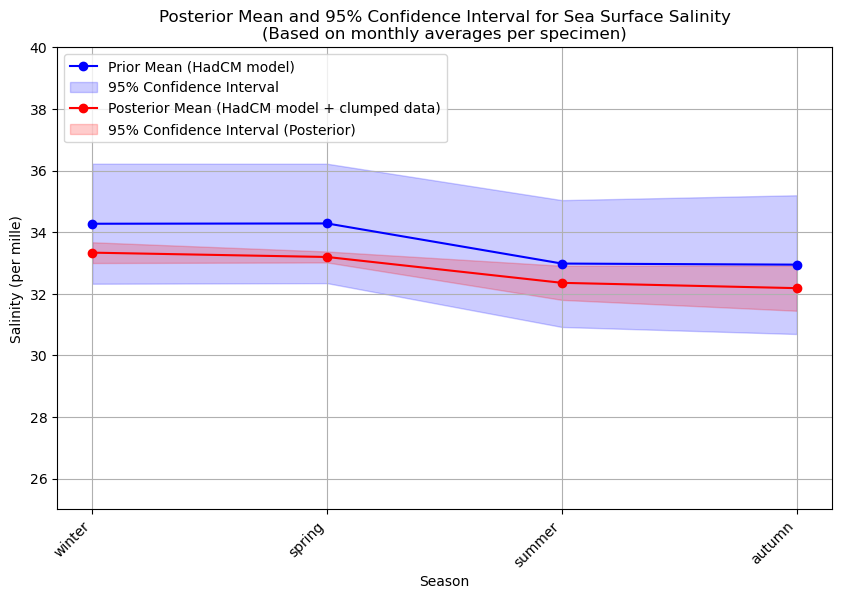

In [150]:
# Plot in temperature domain, set nan values to zero
std_prior_SSS_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_prior_SSS_seasonal_original)))
std_posterior_SSS_seasonal = np.nan_to_num(np.sqrt(np.diag(cov_post_SSS_seasonal)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SSS_seasonal_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SSS_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SSS_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SSS_seasonal, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SSS_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SSS_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_SSS_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_posterior_SSS_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Sea Surface Salinity\n(Based on monthly averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Salinity (per mille)')
plt.ylim(25, 40)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SST and SSS and posterior

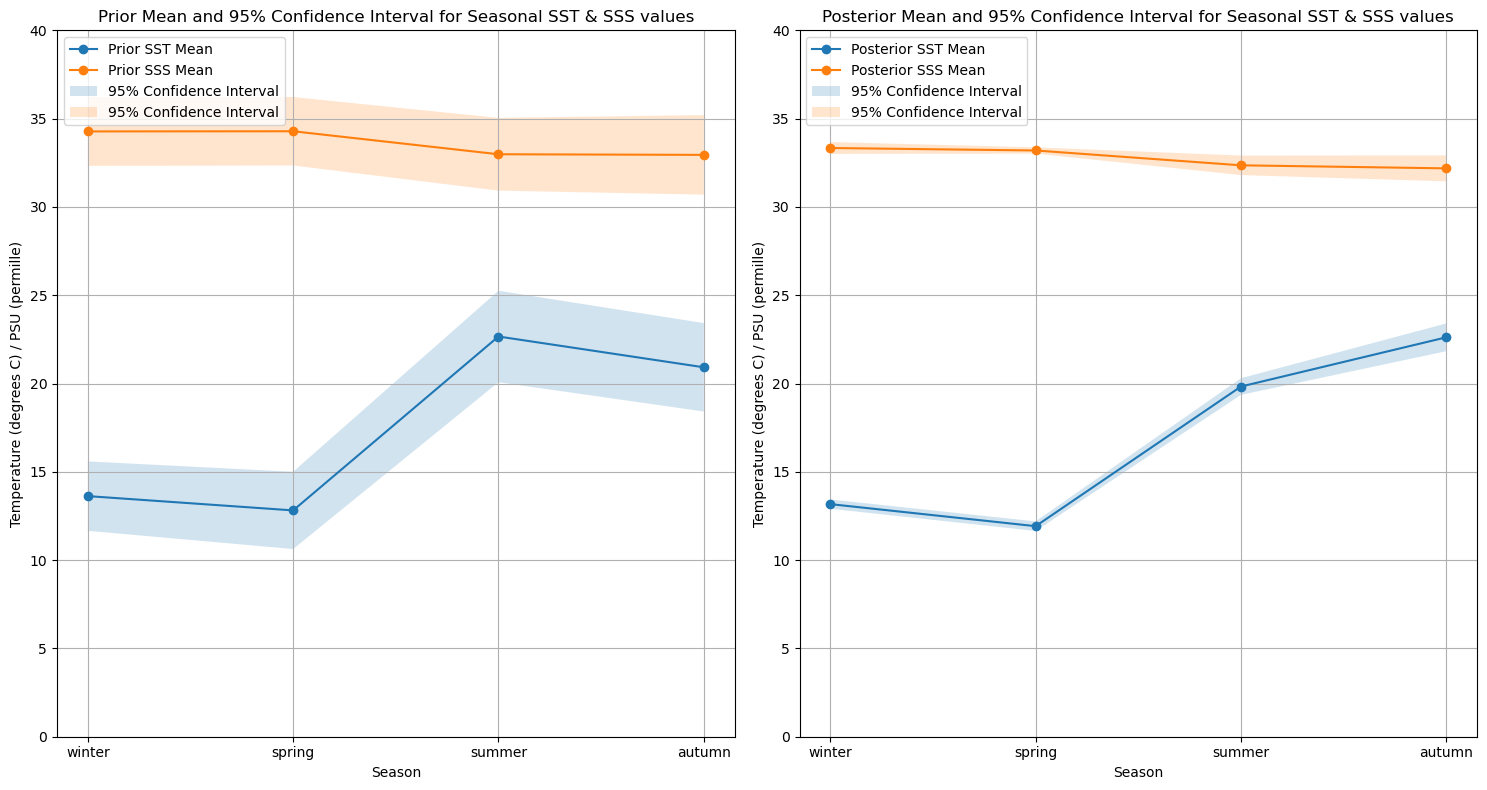

In [151]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SSS
axes[0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o')
axes[0].plot(seasons_scale, mu_prior_SSS_seasonal, label='Prior SSS Mean', marker='o')
axes[0].fill_between(seasons_scale,
                     mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(seasons_scale,
                     mu_prior_SSS_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SSS_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SSS values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C) / PSU (permille)')
axes[0].set_ylim(0, 40)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SSS
axes[1].plot(seasons_scale, mu_posterior_seasonal_T, label='Posterior SST Mean', marker='o')
axes[1].plot(seasons_scale, mu_post_SSS_seasonal, label='Posterior SSS Mean', marker='o')
axes[1].fill_between(seasons_scale,
                     mu_posterior_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_posterior_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(seasons_scale,
                     mu_post_SSS_seasonal - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_SSS_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SSS_seasonal + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_posterior_SSS_seasonal / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SST & SSS values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C) / PSU (permille)')
axes[1].set_ylim(0, 40)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Updated monthly prior in SST and SSS domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 data aggregated as individual datapoints

### Convert seasonal prior, likelihood and posterior to temperature and plot

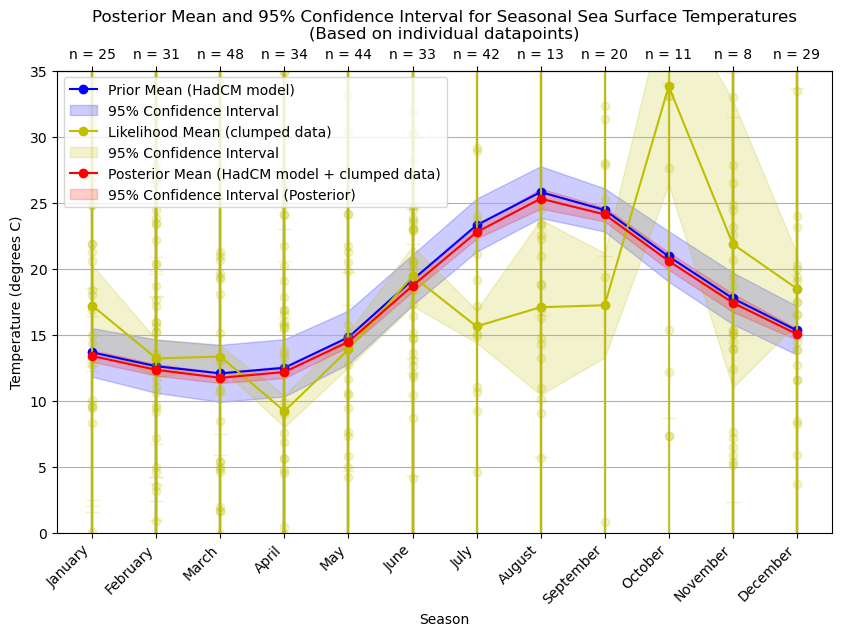

In [152]:
# Convert prior D47 to temp
mu_prior_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly_original, sD47 = cov_prior_D47_monthly_original, return_covar = True)[0]
cov_prior_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_D47_monthly_original, sD47 = cov_prior_D47_monthly_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_monthly_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[0]
cov_likelihood_monthly_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_posterior_monthly_T = D47c.OGLS23.T47(D47 = mu_post_D47_monthly, sD47 = cov_post_D47_monthly, return_covar = True)[0]
cov_posterior_monthly_T = D47c.OGLS23.T47(D47 = mu_post_D47_monthly, sD47 = cov_post_D47_monthly, return_covar = True)[1]

# Plot in temperature domain
std_prior_D47_monthly_T = np.sqrt(np.diag(cov_prior_D47_monthly_T))
std_likelihood_monthly_T = np.sqrt(np.diag(cov_likelihood_monthly_T))
std_posterior_monthly_T = np.sqrt(np.diag(cov_posterior_monthly_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_D47_monthly_T, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_D47_monthly_T / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly),
    mu_likelihood_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in Campanian_D47_data_dict: # Loop over measurements
    plt.plot(measurement["Month"], D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_SD"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["Month"], D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_SD"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_SD"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_posterior_monthly_T, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_posterior_monthly_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    mu_posterior_monthly_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on individual datapoints)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SSS prior and posterior

C:\Users\nwi213\AppData\Local\Temp\ipykernel_12336\1838737548.py:3: RuntimeWarning: invalid value encountered in sqrt
  std_posterior_SSS_monthly = np.nan_to_num(np.sqrt(np.diag(cov_post_SSS_monthly)))


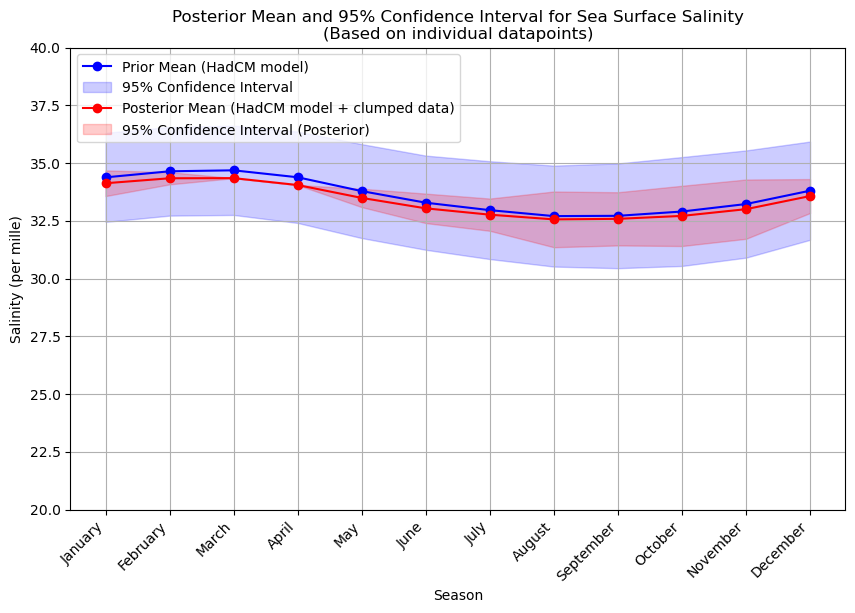

In [154]:
# Plot in temperature domain, set nan values to zero
std_prior_SSS_monthly = np.nan_to_num(np.sqrt(np.diag(cov_prior_SSS_monthly_original)))
std_posterior_SSS_monthly = np.nan_to_num(np.sqrt(np.diag(cov_post_SSS_monthly)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SSS_monthly_original, label = 'Prior Mean (HadCM model)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SSS_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
    mu_prior_SSS_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SSS_monthly, label = 'Posterior Mean (HadCM model + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SSS_monthly - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_SSS_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_SSS_monthly + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_posterior_SSS_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Sea Surface Salinity\n(Based on individual datapoints)')
plt.xlabel('Season')
plt.ylabel('Salinity (per mille)')
plt.ylim(20, 40)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SST and SSS and posterior

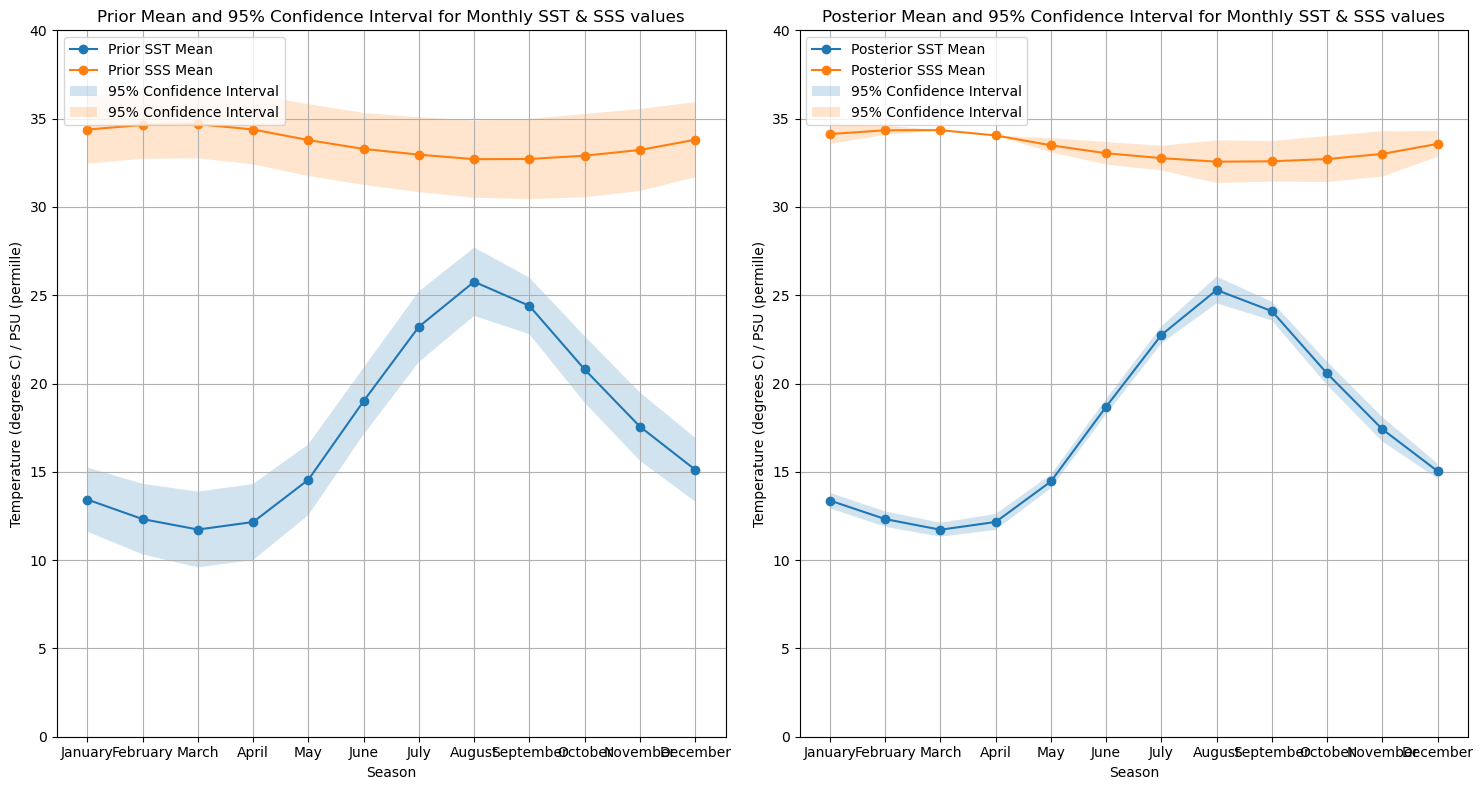

In [155]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SSS
axes[0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o')
axes[0].plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', marker='o')
axes[0].fill_between(months_scale,
                     mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(months_scale,
                     mu_prior_SSS_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SSS_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(months_scale)
axes[0].set_xticklabels(month_names)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST & SSS values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C) / PSU (permille)')
axes[0].set_ylim(0, 40)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SSS
axes[1].plot(months_scale, mu_posterior_monthly_T, label='Posterior SST Mean', marker='o')
axes[1].plot(months_scale, mu_post_SSS_monthly, label='Posterior SSS Mean', marker='o')
axes[1].fill_between(months_scale,
                     mu_posterior_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_posterior_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(months_scale,
                     mu_post_SSS_monthly - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_SSS_monthly / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_post_SSS_monthly + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_posterior_SSS_monthly / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(months_scale)
axes[1].set_xticklabels(month_names)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Monthly SST & SSS values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C) / PSU (permille)')
axes[1].set_ylim(0, 40)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()